In [1]:
import time
import torch
import json
import random
import math
import warnings
import torchvision
import os
import copy
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from datetime import datetime
from tqdm import tqdm
from PIL import Image
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Subset, Dataset, DataLoader
from torchvision.models import EfficientNet

from torchvision.datasets import ImageFolder
from utils.loss_functions import tkd_kdloss
# from models_package.models import Teacher, Student

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# Hyperparameters
learning_rate = 0.0005 # 0.096779
epochs = 100
epochs_pretrain = 3 #3
epochs_optimal_lr = 3 #5
patience_teacher = 1
patience_student = 5
temperature = 4.0
alpha = 0.9
momentum = 0.9
step_size = 30
gamma = 0.1
lmda = 3
batch_size = 76
num_workers = 4

# set to true to use stratified sampling
stratified_sampling_flag = False

# list of lambda values to loop through for grid search
lmda_list_student = [5,3,10,0.5,0]
lmda_list_teacher = [0]

# labels used including for plotting
class_labels = [0, 1, 3, 4, 6, 7, 11, 15, 17, 18, 19, 20, 22, 25, 27, 28, 30, 31, 33, 35, 36, 37, 39, 43, 44, 50, 51, 54, 57, 58]
class_labels_new = torch.tensor([i for i in range(len(class_labels))])
num_classes = 16 #len(class_labels)
class_names_new = [f"Class {label}" for label in range(num_classes)]

# Create directory and file path to save all outputs
output_dir = f'./runs_{datetime.now().strftime("%Y_%m_%d_%H_%M")}'
os.makedirs(output_dir, exist_ok=True)

In [3]:
# set device to cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Assuming your JSON file is named 'your_file.json'
file_path = './WIDER/Annotations/wider_attribute_trainval.json'

with open(file_path, 'r') as file:
    # Load the JSON data from the file
    data = json.load(file)

class_idx = data['scene_id_map']

In [5]:
new_label_mapping = {
    0: "Team_Sports",
    1: "Celebration",
    2: "Parade",
    3: "Waiter_Or_Waitress",
    4: "Individual_Sports",
    5: "Surgeons",
    6: "Spa",
    7: "Law_Enforcement",
    8: "Business",
    9: "Dresses",
    10: "Water Activities",
    11: "Picnic",
    12: "Rescue",
    13: "Cheering",
    14: "Performance_And_Entertainment",
    15: "Family"
}

# Ensure that all 16 new classes are covered
# If some classes are not explicitly mentioned in new_label_mapping, add them
for i in range(16):
    if i not in new_label_mapping:
        new_label_mapping[i] = "Additional Category {}".format(i)

class_idx = new_label_mapping

In [6]:
class StratifiedBatchSampler:
    """Stratified batch sampling
    Provides equal representation of target classes in each batch
    """
    def __init__(self, y, batch_size, shuffle=True):
        if torch.is_tensor(y):
            y = y.numpy()
        assert len(y.shape) == 1, 'label array must be 1D'
        n_batches = int(len(y) / batch_size)
        self.skf = StratifiedKFold(n_splits=n_batches, shuffle=shuffle)
        self.X = torch.randn(len(y),1).numpy()
        self.y = y
        self.shuffle = shuffle
        self.batch_size = batch_size

    def __iter__(self):
        if self.shuffle:
            self.skf.random_state = torch.randint(0,int(1e8),size=()).item()
        for train_idx, test_idx in self.skf.split(self.X, self.y):
            yield test_idx

    def __len__(self):
        return len(self.y)//self.batch_size

In [7]:
class DataSet(Dataset):
    def __init__(self, ann_files, augs, img_size, dataset):

        # Create a mapping from old labels to new labels
        self.label_mapping = {old_label: new_label for new_label, old_label in enumerate(sorted(class_labels))}

        self.new_label_mapping = {
            0: 2,  # Parade
            1: 8,  # Business
            2: 7,  # Law Enforcement
            3: 14,  # Performance and Entertainment
            4: 1,  # Celebration
            5: 13,  # Cheering
            6: 8,  # Business
            7: 8,  # Business
            8: 1,  # Celebration
            9: 14,  # Performance and Entertainment
            10: 15, # Family
            11: 15, # Family
            12: 11, # Picnic
            13: 7, # Law Enforcement
            14: 6, # Spa
            15: 13, # Cheering
            16: 5, # Surgeons
            17: 3, # Waiter or Waitress
            18: 4, # Individual Sports
            19: 0, # Team Sports
            20: 0, # Team Sports
            21: 0, # Team Sports
            22: 4, # Individual Sports
            23: 10, # Water Activities
            24: 4, # Individual Sports
            25: 1, # Celebration
            26: 9, # Dresses
            27: 12, # Rescue
            28: 10,# Water Activities
            29: 0  # Team Sports
        }

        
        self.dataset = dataset
        self.ann_files = ann_files
        self.augment = self.augs_function(augs, img_size)
        # Initialize transformations directly
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize(mean=[0, 0, 0], std=[1, 1, 1])
            ] 
        )
        if self.dataset == "wider":
            self.transform = transforms.Compose(
                [
                    transforms.ToTensor(),
                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])                ] 
            )        

        self.anns = []
        self.load_anns()
        print(self.augment)

    def augs_function(self, augs, img_size):            
        t = []
        if 'randomflip' in augs:
            t.append(transforms.RandomHorizontalFlip())
        if 'ColorJitter' in augs:
            t.append(transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0))
        if 'resizedcrop' in augs:
            t.append(transforms.RandomResizedCrop(img_size, scale=(0.7, 1.0)))
        if 'RandAugment' in augs:
            t.append(transforms.RandAugment())

        t.append(transforms.Resize((img_size, img_size)))

        return transforms.Compose(t)
    
    def load_anns(self):
        self.anns = []
        for ann_file in self.ann_files:
            json_data = json.load(open(ann_file, "r"))
            self.anns += json_data

    def __len__(self):
        return len(self.anns)

    def __getitem__(self, idx):
        # Make sure the index is within bounds
        idx = idx % len(self)
        ann = self.anns[idx]
        
        try:
            # Attempt to open the image file
            img = Image.open(f'WIDER/Image/{ann["file_name"]}').convert("RGB")

            # If this is the wider dataset, proceed with specific processing
            # x, y, w, h = ann['bbox']
            # img_area = img.crop([x, y, x+w, y+h])
            img_area = self.augment(img)
            img_area = self.transform(img_area)
            attributes_list = [target['attribute'] for target in ann['targets']]
            num_people = len(attributes_list)
            attributes_distribution = [max(sum(attribute), 0)/num_people for attribute in zip(*attributes_list)]
            # Extract label from image path
            img_path = f'WIDER/Image/{ann["file_name"]}'
            label = self.extract_label(img_path)  # You might need to implement this method
            
            return {
                "label": label,
                "target": torch.tensor([attributes_distribution[0]], dtype=torch.float32),
                "img": img_area
            }
            
        except Exception as e:
            # If any error occurs during the processing of an image, log the error and the index
            print(f"Error processing image at index {idx}: {e}")
            # Instead of returning None, raise the exception
            raise

    def extract_label(self, img_path):
        original_label = None
    
        if "WIDER/Image/train" in img_path:
            label_str = img_path.split("WIDER/Image/train/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/test" in img_path:
            label_str = img_path.split("WIDER/Image/test/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
        elif "WIDER/Image/val" in img_path:  # Handle validation images
            label_str = img_path.split("WIDER/Image/val/")[1].split("/")[0]
            original_label = int(label_str.split("--")[0])
    
        if original_label is not None:
            remapped_label = self.label_mapping[original_label]
            new_label_mapping = self.new_label_mapping[remapped_label]
            return new_label_mapping
        else:
            raise ValueError(f"Label could not be extracted from path: {img_path}")


In [8]:
train_file = ['data/wider/trainval_wider.json']
test_file = ['data/wider/test_wider.json']


In [9]:
def custom_collate(batch):
    # Filter out any None items in the batch
    batch = [item for item in batch if item is not None]
    # If after filtering the batch is empty, handle this case by either returning an empty tensor or raising an exception
    if len(batch) == 0:
        raise ValueError("Batch is empty after filtering out None items.")
    return torch.utils.data.dataloader.default_collate(batch)


In [10]:
train_dataset = DataSet(train_file, augs = [], img_size = 226, dataset = 'wider')
test_dataset = DataSet(test_file, augs = [], img_size = 226, dataset = 'wider')


if stratified_sampling_flag:
    trainloader = DataLoader(train_dataset, 
                             batch_sampler=StratifiedBatchSampler(torch.tensor([train_dataset[i]['label'] for i in range(len(train_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_sampler=StratifiedBatchSampler(torch.tensor([test_dataset[i]['label'] for i in range(len(test_dataset))]), 
                             batch_size=batch_size), num_workers=num_workers, collate_fn=custom_collate)
else:
    trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                             num_workers=num_workers, collate_fn=custom_collate)
    testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=custom_collate)

Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)
Compose(
    Resize(size=(226, 226), interpolation=bilinear, max_size=None, antialias=warn)
)


In [11]:
len(train_dataset)

10324

# Start Training Process

In [12]:
def one_hot_encode(labels, num_classes):
    return np.eye(num_classes)[labels]

def calculate_recall_multiclass(conf_matrix):
    recalls = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    recalls[np.isnan(recalls)] = 0  # Replace NaN with 0
    return recalls

def evaluate_model_with_gender_multiclass(pred, label, gender, num_classes):
    predictions = pred.cpu()
    true_labels = label.cpu()
    gender = gender.cpu()

    # Identify male and female indices based on the gender threshold
    male_indices = np.where(gender >= 0.5)[0]
    female_indices = np.where(gender < 0.5)[0]

    # Convert labels to one-hot encoding
    one_hot_labels = one_hot_encode(true_labels, num_classes=num_classes)
    one_hot_preds = one_hot_encode(predictions, num_classes=num_classes)
    # Initialize recall arrays
    male_recall = np.zeros(num_classes)
    female_recall = np.zeros(num_classes)

    # Extract predictions and labels for male and female indices
    male_predictions = np.argmax(one_hot_preds[male_indices], axis=1)
    female_predictions = np.argmax(one_hot_preds[female_indices], axis=1)
    male_labels = np.argmax(one_hot_labels[male_indices], axis=1)
    female_labels = np.argmax(one_hot_labels[female_indices], axis=1)

    # Check if the class labels are within the expected range
    assert (0 <= male_predictions.min() < num_classes) and (0 <= male_predictions.max() < num_classes), "Invalid class indices in male predictions"
    assert (0 <= female_predictions.min() < num_classes) and (0 <= female_predictions.max() < num_classes), "Invalid class indices in female predictions"
    assert (0 <= male_labels.min() < num_classes) and (0 <= male_labels.max() < num_classes), "Invalid class indices in male labels"
    assert (0 <= female_labels.min() < num_classes) and (0 <= female_labels.max() < num_classes), "Invalid class indices in female labels"

    # Calculate confusion matrices for each gender
    male_conf_matrix = confusion_matrix(male_labels, male_predictions, labels=np.arange(num_classes))
    female_conf_matrix = confusion_matrix(female_labels, female_predictions, labels=np.arange(num_classes))

    # Calculate recall for each class and gender
    male_recall[:len(male_conf_matrix)] = calculate_recall_multiclass(male_conf_matrix)
    female_recall[:len(female_conf_matrix)] = calculate_recall_multiclass(female_conf_matrix)

    return male_recall - female_recall, male_conf_matrix, female_conf_matrix


In [13]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')
teacher_model.classifier = nn.Linear(1536, num_classes)
student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
student_model.classifier = nn.Linear(1280, num_classes)

# Load teacher
# teacher_model = torch.load('teacher_model_ckd_wider.pth')
# teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider.pth'))
# torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_wider.pth')
# # Load the studnet
# student_model = torch.load('student_model_ckd_prof.pth')
# student_model.load_state_dict(torch.load('student_model_weights_ckd_prof_checkpoint.pth'))
# student_model = student_model.to(device)


This is the initialization of the 2-layer Adversary Perceptron. It is initialized with the number of classes*2, which represents the predicted labels (y_hat) and the true labels (y). The output of the final layer is a regression output, which is intended to predict the strength of gender (continuous number where anything past 0.5 is more male).


In [14]:
class Adversary(nn.Module):
    def __init__(self, input_size=num_classes):
        super(Adversary, self).__init__()

        self.a1 = nn.Linear(input_size*2, 16)
        self.a2 = nn.Linear(16, 1)  # Output size 1 for regression
        nn.init.xavier_normal_(self.a1.weight)
        nn.init.kaiming_normal_(self.a2.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, input_ids):
        adversary = F.relu(self.a1(input_ids))
        adversary_output = F.sigmoid(self.a2(adversary))  # Linear activation for regression
        return adversary_output

# Instantiate the Adversary
adv = Adversary()

In [15]:
def pretrain_student(student, teacher, trainloader, criterion, optimizer, device, alpha, temperature, epochs_pretrain, patience=patience_student):
    teacher.eval()
    teacher.to(device)
    best_val_loss = float('inf')  
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        student.train()
        student.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):

            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)

            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            # If not scalar, sum up to make sure the loss is scalar
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()
                
            # Now combine the losses
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        student_epoch_losses.append(epoch_loss)


In [16]:
def pretrain_teacher(teacher, trainloader, criterion, optimizer, device, epochs_pretrain, patience=patience_student):
    teacher.to(device)
    teacher.train()  # Set the model to training mode
    best_val_loss = float('inf')  
    patience_counter = 0 
    teacher_epoch_losses = []
    val_losses = []
    
    for epoch in range(epochs_pretrain):
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            optimizer.zero_grad()
            teacher_outputs = teacher(inputs)

            ce_loss = criterion(teacher_outputs, labels)
                
            loss = ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1
        
        epoch_loss /= num_batches
        print(f'*******Epoch {epoch}: loss - {epoch_loss}')
        teacher_epoch_losses.append(epoch_loss)


In [17]:
def pretrain_adversary(adv, student, adversary_optimizer, trainloader, adv_criterion, device, epochs_pretrain):

  for epoch in range(epochs_pretrain):
    epoch_loss = 0
    epoch_batches = 0
    for i, data in enumerate(tqdm(trainloader)): # starting from the 0th batch
        # get the inputs and labels
        adv.train()
        adv.to(device)
        inputs = data['img'].to(device)
        labels = data['label'].to(device)
        targets = data['target'].to(device)
        student = student.to(device)
        adversary_optimizer.zero_grad()
        student_output = student(inputs)
        one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
        concatenated_output = torch.cat((student_output, one_hot_labels), dim=1)
        adversary_output = adv(concatenated_output)
        adversary_loss = adv_criterion(adversary_output, targets) # compute loss
        adversary_loss.backward() # back prop
        adversary_optimizer.step()
        epoch_loss += adversary_loss.item()
        epoch_batches += 1

    print("Average Pretrain Adversary epoch loss: ", epoch_loss/epoch_batches)


In [18]:
# Optimizer and scheduler for the student model
student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

# Instantiate the model and the loss function
criterion_clf = nn.CrossEntropyLoss()
adv_criterion = nn.MSELoss()


In [19]:
def plot_loss_curve(losses):
    epochs = range(1, len(losses) + 1)
    plt.plot(epochs, losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Val Loss Curve')
    plt.show()

In [20]:
# This is the adversary training function, where we input the student outputs, 
# with the true labels into the adversary model created previously.
def train_adversary(adv, model, optimizer, trainloader, criterion, epochs):
    best_val_loss = float('inf')
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_batches = 0
        for i, data in enumerate(tqdm(trainloader)):
            # get the inputs and labels
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            model.eval()
            model.to(device)
            adv.train()
            adv.to(device)
            optimizer.zero_grad()
            # output the student model, join with ohe labels. 
            model_output = model(inputs)
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((model_output, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)

            adversary_loss = criterion(adversary_output, targets)
            adversary_loss.backward()
            epoch_loss += adversary_loss.item()
            epoch_batches += 1
            optimizer.step()
        epoch_loss/=epoch_batches
        print("Average Adversary epoch loss:", epoch_loss)

In [21]:
# Function to train the teacher model


def train_teacher(model, adv, trainloader, criterion, adv_criterion, optimizer, optimizer_adv, device, 
                  epochs, lmda, patience=patience_teacher):

    best_val_loss = float('inf')
    patience_counter = 0
    epoch_losses = [] 
    val_losses = []
    val_disparities = []
    val_accuracies = []
    best_total_val_loss = float('inf')

    for epoch in range(epochs):
        model.train()
        adv.train()
        model.to(device)
        adv.to(device)
        running_loss = 0.0
        epoch_loss = 0.0  
        num_batches = 0  
        
        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
        
            # Forward pass for teacher model
            optimizer.zero_grad()
            outputs = model(inputs)
            classification_loss = criterion(outputs, labels)
        
            # Forward pass for adversary model
            optimizer_adv.zero_grad()
            with torch.no_grad():
                teacher_outputs_detached = outputs.detach()
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((teacher_outputs_detached, one_hot_labels), dim=1)
            adversary_output = adv(concatenated_output)
            adversary_loss = adv_criterion(adversary_output, targets)
        
            # Calculate the total loss by combining classification and adversary loss
            if lmda != 0:
                total_loss = classification_loss + classification_loss/adversary_loss - lmda * adversary_loss
            else:
                total_loss = classification_loss
                
            total_loss.backward()
        
            optimizer.step()
            optimizer_adv.step()
        
            running_loss += total_loss.item()
            epoch_loss += total_loss.item()
            num_batches += 1

        epoch_loss /= num_batches  
        epoch_losses.append(epoch_loss)

        model.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))
        
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                val_outputs = model(val_inputs)
                with torch.no_grad():
                    teacher_outputs_detached_val = val_outputs.detach()                
                one_hot_labels_val = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                concatenated_output_val = torch.cat((teacher_outputs_detached_val, one_hot_labels_val), dim=1)
                adversary_output_val = adv(concatenated_output_val)
                adversary_loss_val = adv_criterion(adversary_output_val, val_targets)
                
                # Compute validation loss
                val_ce_loss = criterion(val_outputs, val_labels)

                if lmda !=0:
                    val_loss = val_ce_loss + val_ce_loss/adversary_loss_val - lmda * adversary_loss_val
                else:
                    val_loss = val_ce_loss
                    
                total_val_loss += val_loss.item()

                # Compute the validation accuracy
                _, predicted = torch.max(val_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1

                # Compute recall differences for gender
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]

            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches
            
            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")
        
        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0 
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(model.state_dict(), f'teacher_model_weights_ckd_prof_checkpoint{lmda}.pth')
            torch.save(model, f'teacher_model_ckd_prof_checkpoint{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
        
    plot_loss_curve(val_losses)
    print("Finished Training Teacher")
    return val_disparities


# Function to train the student model with knowledge distillation
def train_student_with_distillation_disparity(student, teacher, adv, trainloader, testloader, criterion, adv_criterion, optimizer, 
                                              device, alpha, temperature, epochs, lmda, patience=patience_student, optimizer_adv=None):
    teacher.eval()
    teacher.to(device)
    best_val_accuracy = 0
    best_total_val_loss = float('inf')
    best_epoch_accuracy = 0.0
    best_epoch_disparity = 0.0
    patience_counter = 0 
    student_epoch_losses = []
    val_losses = []
    val_disparities = []
    val_accuracies = []

    for epoch in range(epochs):
        if lmda != 0:
        # Train the adversary at the start of each epoch
            train_adversary(adv, student, optimizer_adv, trainloader, adv_criterion, 1)

        student.train()
        student.to(device)
        adv.eval()
        adv.to(device)
        running_loss = 0.0 
        epoch_loss = 0.0  
        num_batches = 0 
        confusion_male = np.zeros((num_classes, num_classes))
        confusion_female = np.zeros((num_classes, num_classes))

        for index, data in enumerate(tqdm(trainloader)):
            inputs = data['img'].to(device)
            labels = data['label'].to(device)
            targets = data['target'].to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)

            # detach student_outputs to avoid exploding gradients by passing same inputs (with gradience) into two different models. 
            studentached = student_outputs.detach()
            # One-hot encode labels and concatenate with student's predictions
            one_hot_labels = F.one_hot(labels, num_classes=num_classes).to(torch.float32)
            concatenated_output = torch.cat((studentached, one_hot_labels), dim=1)

            # Run the adversarial model on concatenated true labels, and predicted labels
            with torch.no_grad():
                adversary_output = adv(concatenated_output)

            # Calc adversary loss, which is an MSE loss, because this is a regression output. 
            adversary_loss = adv_criterion(adversary_output, targets)
            ce_loss = criterion(student_outputs, labels)
            kd_loss = tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
            
            if kd_loss.ndim != 0:
                kd_loss = kd_loss.sum()

            # Now combine the losses, subtract weighted adversary loss because we need to maximize that loss 
            # goal of the model is to have the adversary not predict gender. 
            if lmda != 0:
                loss = (alpha * kd_loss + (1 - alpha) * ce_loss) + (alpha * kd_loss + (1 - alpha) * ce_loss)/adversary_loss - lmda * adversary_loss
            else:
                loss = alpha * kd_loss + (1 - alpha) * ce_loss
                
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_loss += loss.item()
            num_batches += 1

        epoch_loss /= num_batches
        # print(f'*******Epoch {epoch}: running_recall_with - {running_recall_with/num_batches}  |  running_recall_without - {running_recall_without/num_batches}  |  disparity - {epoch_disparity/num_batches}******')
        student_epoch_losses.append(epoch_loss)

        student.eval()
        total_correct = 0
        total_samples = 0
        total_val_loss = 0.0
        num_batches = 0
        # Validation after each epoch
        with torch.no_grad():
            for val_data in tqdm(testloader):
                val_inputs = val_data['img'].to(device)
                val_labels = val_data['label'].to(device)
                val_targets = val_data['target'].to(device)
                
                # Forward pass for validation
                val_student_outputs = student(val_inputs)
                val_teacher_outputs = teacher(val_inputs)

                val_studentached = val_student_outputs.detach()   
                val_one_hot_labels = F.one_hot(val_labels, num_classes=num_classes).to(torch.float32)
                val_concatenated_output = torch.cat((val_studentached, val_one_hot_labels), dim=1)
                
                val_adversary_output = adv(val_concatenated_output)
                val_adversary_loss = adv_criterion(val_adversary_output, val_targets)
                val_ce_loss = criterion(val_student_outputs, val_labels)
                val_kd_loss = tkd_kdloss(val_student_outputs, val_teacher_outputs, temperature=temperature)  # Make sure this returns a scalar
                
                if val_kd_loss.ndim != 0:
                    val_kd_loss = val_kd_loss.sum()
                if lmda != 0:
                    val_loss = (alpha * val_kd_loss + (1 - alpha) * val_ce_loss) + (alpha * val_kd_loss + (1 - alpha) * val_ce_loss)/val_adversary_loss - lmda * val_adversary_loss
                else:
                    val_loss = alpha * val_kd_loss + (1 - alpha) * val_ce_loss
                total_val_loss += val_loss.item()
    
                # Compute the validation accuracy
                _, predicted = torch.max(val_student_outputs, 1)
                total_samples += val_labels.size(0)
                total_correct += (predicted == val_labels).sum().item()
                num_batches += 1
                recall_diff = evaluate_model_with_gender_multiclass(predicted, val_labels, val_targets, num_classes=num_classes)
                confusion_male += recall_diff[1]
                confusion_female += recall_diff[2]
    
            total_val_loss /= num_batches
            confusion_male /= num_batches
            confusion_female /= num_batches

            epoch_disparity = calculate_recall_multiclass(confusion_male) - calculate_recall_multiclass(confusion_female)
            val_losses.append(total_val_loss)
            non_zero_abs_values = np.abs(epoch_disparity[epoch_disparity != 0])
            mean_non_zero_abs_disparity = np.mean(non_zero_abs_values)
            val_disparities.append(mean_non_zero_abs_disparity)
            accuracy = total_correct / total_samples
            val_accuracies.append(accuracy)
            print(f'*****Epoch {epoch + 1}/{epochs}*****\n' 
            f'*****Train Loss: {epoch_loss: .6f} Val Loss: {total_val_loss: .6f}*****\n'
            f'*****Validation Accuracy: {accuracy * 100:.2f}%*****\n'
            f'*****Total Avg Disparity: {mean_non_zero_abs_disparity}*****\n')
            class_recall_mapping = {class_name: epoch_disparity[int(class_label)] for class_label, class_name in class_idx.items()}
            
            # Print disparities by class label
            for class_label, recall_diff in class_recall_mapping.items():
                print(f"Class {class_label}: Recall Difference = {recall_diff}")

        # Check for early stopping
        if abs(total_val_loss) < abs(best_total_val_loss):
            best_total_val_loss = total_val_loss
            patience_counter = 0
            best_epoch_mean_abs_disparity = mean_non_zero_abs_disparity
            torch.save(student.state_dict(), f'student_model_weights_ckd_wider_checkpoint_lambda{lmda}.pth')
            torch.save(student, f'student_model_ckd_wider_checkpoint_lambda{lmda}.pth')
        else:
            patience_counter += 1 

        if patience_counter >= patience:
            print('Early stopping')
            break  
    
        file_path = os.path.join(output_dir, f'validation_{lmda}.txt')
        
        # Append data to the text file
        with open(file_path, 'a') as file:
            file.write(f'********Epoch: {epoch}***********')
            
            file.write("Val Accuracies:\n")
            for accuracy in val_accuracies:
                file.write(f"{accuracy}\n")
        
            file.write("\nVal Disparities:\n")
            for disparity in val_disparities:
                file.write(f"{disparity}\n")

            for class_label, recall_diff in class_recall_mapping.items():
                file.write(f"Class {class_label}: Recall Difference = {recall_diff}\n")
        
        
        print(f"Data has been appended to {file_path}")
    plot_loss_curve(val_losses)
                
    return best_epoch_mean_abs_disparity

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.42it/s]


*****Epoch 1/100*****
*****Train Loss:  0.020275 Val Loss:  2.868853*****
*****Validation Accuracy: 61.18%*****
*****Total Avg Disparity: 0.15564200258902472*****

Class Team_Sports: Recall Difference = 0.07133765399661363
Class Celebration: Recall Difference = -0.08139534883720928
Class Parade: Recall Difference = 0.135116115411682
Class Waiter_Or_Waitress: Recall Difference = -0.2460992907801418
Class Individual_Sports: Recall Difference = -0.15698067814450034
Class Surgeons: Recall Difference = 0.06446886446886446
Class Spa: Recall Difference = -0.326241134751773
Class Law_Enforcement: Recall Difference = 0.1700191570881226
Class Business: Recall Difference = -0.11317135549872126
Class Dresses: Recall Difference = -0.7083333333333334
Class Water Activities: Recall Difference = 0.07479886931941715
Class Picnic: Recall Difference = -0.05555555555555547
Class Rescue: Recall Difference = 0.06888423258250387
Class Cheering: Recall Difference = 0.0036824877250409283
Class Performance_And_

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.50it/s]


*****Epoch 2/100*****
*****Train Loss:  0.024760 Val Loss:  2.758181*****
*****Validation Accuracy: 62.02%*****
*****Total Avg Disparity: 0.15006298657450795*****

Class Team_Sports: Recall Difference = 0.06471652945641382
Class Celebration: Recall Difference = -0.1511627906976744
Class Parade: Recall Difference = 0.043162092423176146
Class Waiter_Or_Waitress: Recall Difference = -0.25531914893617014
Class Individual_Sports: Recall Difference = -0.11807382903541097
Class Surgeons: Recall Difference = 0.032967032967033016
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.19468390804597702
Class Business: Recall Difference = -0.027067348678601832
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.12741900413133267
Class Picnic: Recall Difference = -0.01851851851851849
Class Rescue: Recall Difference = 0.04007333682556313
Class Cheering: Recall Difference = 0.028027823240589167
Class Performance

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 3/100*****
*****Train Loss:  0.029634 Val Loss:  2.735480*****
*****Validation Accuracy: 61.39%*****
*****Total Avg Disparity: 0.15624471789547478*****

Class Team_Sports: Recall Difference = 0.08025923979681204
Class Celebration: Recall Difference = -0.08604651162790689
Class Parade: Recall Difference = 0.12291813277034946
Class Waiter_Or_Waitress: Recall Difference = -0.1780141843971631
Class Individual_Sports: Recall Difference = -0.21374332756935555
Class Surgeons: Recall Difference = 0.08424908424908417
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.14272030651341006
Class Business: Recall Difference = -0.08056265984654731
Class Dresses: Recall Difference = -0.6666666666666666
Class Water Activities: Recall Difference = 0.14905414220482693
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = 0.05683603981141966
Class Cheering: Recall Difference = 0.00327332242225864
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:18<00:00,  2.46it/s]


*****Epoch 4/100*****
*****Train Loss:  0.016046 Val Loss:  2.661736*****
*****Validation Accuracy: 61.70%*****
*****Total Avg Disparity: 0.1578033788652456*****

Class Team_Sports: Recall Difference = 0.05315583581479544
Class Celebration: Recall Difference = 0.03720930232558134
Class Parade: Recall Difference = 0.09230588787239014
Class Waiter_Or_Waitress: Recall Difference = -0.2432624113475178
Class Individual_Sports: Recall Difference = -0.12517855800315758
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.2224616858237548
Class Business: Recall Difference = -0.10656436487638538
Class Dresses: Recall Difference = -0.5857142857142856
Class Water Activities: Recall Difference = 0.11372037399434665
Class Picnic: Recall Difference = -0.29629629629629634
Class Rescue: Recall Difference = 0.05212152959664745
Class Cheering: Recall Difference = 0.041734860883797076
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.42it/s]


*****Epoch 5/100*****
*****Train Loss:  0.009930 Val Loss:  2.799024*****
*****Validation Accuracy: 61.88%*****
*****Total Avg Disparity: 0.1450742264014932*****

Class Team_Sports: Recall Difference = 0.0808781456180302
Class Celebration: Recall Difference = -0.00930232558139521
Class Parade: Recall Difference = 0.08526859019469868
Class Waiter_Or_Waitress: Recall Difference = -0.24468085106382975
Class Individual_Sports: Recall Difference = -0.13923765130441323
Class Surgeons: Recall Difference = 0.058608058608058566
Class Spa: Recall Difference = -0.28368794326241137
Class Law_Enforcement: Recall Difference = 0.16044061302681978
Class Business: Recall Difference = -0.14684569479965898
Class Dresses: Recall Difference = -0.5142857142857142
Class Water Activities: Recall Difference = 0.1973255055446837
Class Picnic: Recall Difference = -0.25925925925925936
Class Rescue: Recall Difference = -0.017810371922472534
Class Cheering: Recall Difference = -0.0018412438625204919
Class Performan

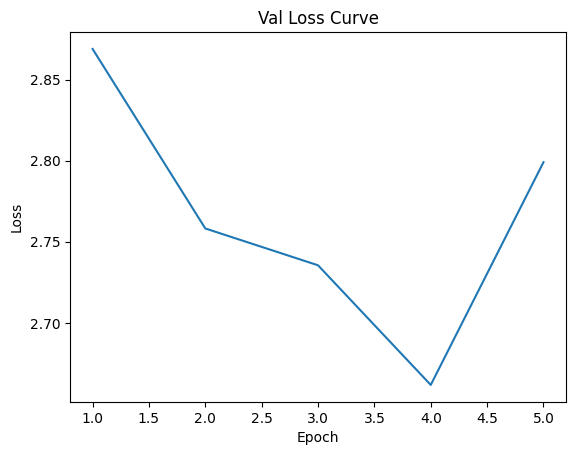

Finished Training Teacher
Teacher weights and architecture saved and exported for lambda: 0


In [36]:
# Initialize the dictionary for results
lambda_results = {}

# Loop for training the teacher model with different lambda values
for i in lmda_list_teacher:
    # Reset the teacher model for each lambda
    # teacher_model = torchvision.models.efficientnet_b3(weights='DEFAULT')    
    # # Replace the last fully connected layer with a new one
    # teacher_model.classifier = nn.Linear(1536, num_classes)
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    teacher_optimizer = optim.Adam(teacher_model.parameters(), lr=learning_rate)
    
    # Initialize the adversary for the teacher
    adv = Adversary()
    teacher_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)

    # pretrain_teacher(teacher_model, trainloader, criterion_clf, teacher_optimizer, device, epochs_pretrain)
    # pretrain_adversary(adv, student_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    # Train the teacher model with adversarial training
    teacher_mean_abs_val_disparity = train_teacher(teacher_model, adv, trainloader, criterion_clf, adv_criterion, teacher_optimizer, teacher_optimizer_adv, device, epochs, i, patience=patience_teacher)

    # Save the teacher model and its state
    torch.save(teacher_model.state_dict(), f'teacher_model_weights_ckd_wider_lambda{i}2.pth')
    torch.save(teacher_model, f'teacher_model_ckd_wider_lambda{i}2.pth')
    print('Teacher weights and architecture saved and exported for lambda:', i)

    # Store the teacher results in the dictionary
    lambda_results[i] = {
        'teacher_mean_abs_val_disparity': teacher_mean_abs_val_disparity
    }


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4370732184718638


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.9018331288414843


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.6070701490868541


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3853460448410581


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.38551894925972996


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.3854000152033918


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.3222210206748808


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 1/100*****
*****Train Loss:  2.144697 Val Loss:  3.000405*****
*****Validation Accuracy: 60.92%*****
*****Total Avg Disparity: 0.13893691792103852*****

Class Team_Sports: Recall Difference = 0.06089799731418244
Class Celebration: Recall Difference = 0.025581395348837188
Class Parade: Recall Difference = 0.14919071076706547
Class Waiter_Or_Waitress: Recall Difference = -0.17659574468085115
Class Individual_Sports: Recall Difference = -0.18164047815953688
Class Surgeons: Recall Difference = -0.015384615384615385
Class Spa: Recall Difference = -0.4539007092198581
Class Law_Enforcement: Recall Difference = 0.10416666666666674
Class Business: Recall Difference = 0.02408354646206301
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.1347031963470321
Class Picnic: Recall Difference = -0.0185185185185186
Class Rescue: Recall Difference = 0.015976951283394436
Class Cheering: Recall Difference = -0.07937806873977082
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.24858495812205708


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 2/100*****
*****Train Loss:  0.641662 Val Loss:  2.958690*****
*****Validation Accuracy: 63.29%*****
*****Total Avg Disparity: 0.1459562811502919*****

Class Team_Sports: Recall Difference = 0.026612950312372097
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = 0.07318789584799457
Class Waiter_Or_Waitress: Recall Difference = -0.1950354609929078
Class Individual_Sports: Recall Difference = -0.1425832644162095
Class Surgeons: Recall Difference = 0.00439560439560438
Class Spa: Recall Difference = -0.2056737588652483
Class Law_Enforcement: Recall Difference = 0.08022030651340994
Class Business: Recall Difference = 0.11317135549872137
Class Dresses: Recall Difference = -0.6964285714285714
Class Water Activities: Recall Difference = 0.12741900413133278
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.11707700366684132
Class Cheering: Recall Difference = 0.05626022913256962
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.25984670013627587


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 3/100*****
*****Train Loss: -0.150035 Val Loss:  3.254675*****
*****Validation Accuracy: 62.60%*****
*****Total Avg Disparity: 0.12008098319633709*****

Class Team_Sports: Recall Difference = 0.03177439131196369
Class Celebration: Recall Difference = 0.0023255813953488857
Class Parade: Recall Difference = 0.11529439361951666
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120563
Class Individual_Sports: Recall Difference = -0.11446507781369819
Class Surgeons: Recall Difference = 0.0043956043956044355
Class Spa: Recall Difference = 0.0921985815602836
Class Law_Enforcement: Recall Difference = 0.06992337164750961
Class Business: Recall Difference = 0.025149190110826947
Class Dresses: Recall Difference = -0.7440476190476191
Class Water Activities: Recall Difference = 0.13100674059578166
Class Picnic: Recall Difference = 0.07407407407407396
Class Rescue: Recall Difference = -0.0010476689366160086
Class Cheering: Recall Difference = -0.04644026186579375
Class Performa

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.25843543636009975


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 4/100*****
*****Train Loss: -0.469328 Val Loss:  4.049432*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.14456916484224747*****

Class Team_Sports: Recall Difference = 0.02543352601156068
Class Celebration: Recall Difference = -0.12325581395348839
Class Parade: Recall Difference = 0.05019939010086805
Class Waiter_Or_Waitress: Recall Difference = -0.2567375886524823
Class Individual_Sports: Recall Difference = -0.14634238027216007
Class Surgeons: Recall Difference = -0.02417582417582409
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.08740421455938696
Class Business: Recall Difference = 0.08269394714407513
Class Dresses: Recall Difference = -0.4428571428571429
Class Water Activities: Recall Difference = 0.17503805175038045
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.14117338920900996
Class Cheering: Recall Difference = 0.017798690671031125
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.25363883759607286


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 5/100*****
*****Train Loss: -0.604717 Val Loss:  3.492506*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.13326449869083717*****

Class Team_Sports: Recall Difference = 0.05719623985519939
Class Celebration: Recall Difference = 0.03023255813953496
Class Parade: Recall Difference = 0.13441238564391278
Class Waiter_Or_Waitress: Recall Difference = -0.25248226950354613
Class Individual_Sports: Recall Difference = -0.13916246898729434
Class Surgeons: Recall Difference = 0.08424908424908423
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.11111111111111116
Class Business: Recall Difference = 0.054560954816709306
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.11372037399434665
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.14353064431639612
Class Cheering: Recall Difference = 0.019844517184942734
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2517430283786619


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 6/100*****
*****Train Loss: -0.694729 Val Loss:  3.616776*****
*****Validation Accuracy: 64.27%*****
*****Total Avg Disparity: 0.13283205002027076*****

Class Team_Sports: Recall Difference = 0.0025923979681204967
Class Celebration: Recall Difference = 0.011627906976744207
Class Parade: Recall Difference = 0.16314801782782062
Class Waiter_Or_Waitress: Recall Difference = -0.28581560283687946
Class Individual_Sports: Recall Difference = -0.16780693180963835
Class Surgeons: Recall Difference = 0.00439560439560438
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.11494252873563215
Class Business: Recall Difference = 0.040494458653026366
Class Dresses: Recall Difference = -0.5619047619047619
Class Water Activities: Recall Difference = 0.12241791693846493
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = 0.23520167627029848
Class Cheering: Recall Difference = -0.11743044189852703
Class Performan

100%|█████████████████████████████████████████| 136/136 [00:57<00:00,  2.35it/s]


Average Adversary epoch loss: 0.24292311455835314


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 7/100*****
*****Train Loss: -0.681985 Val Loss:  3.695218*****
*****Validation Accuracy: 63.58%*****
*****Total Avg Disparity: 0.11472640655851613*****

Class Team_Sports: Recall Difference = 0.0199334384305484
Class Celebration: Recall Difference = -0.0046511627906976605
Class Parade: Recall Difference = 0.0826882477128783
Class Waiter_Or_Waitress: Recall Difference = -0.15673758865248222
Class Individual_Sports: Recall Difference = -0.07909179760920226
Class Surgeons: Recall Difference = 0.10989010989010989
Class Spa: Recall Difference = -0.13475177304964547
Class Law_Enforcement: Recall Difference = 0.09099616858237547
Class Business: Recall Difference = 0.02280477408354642
Class Dresses: Recall Difference = -0.5499999999999998
Class Water Activities: Recall Difference = 0.14840182648401823
Class Picnic: Recall Difference = -0.05555555555555558
Class Rescue: Recall Difference = 0.12205343111576739
Class Cheering: Recall Difference = 0.04623567921440269
Class Performance_A

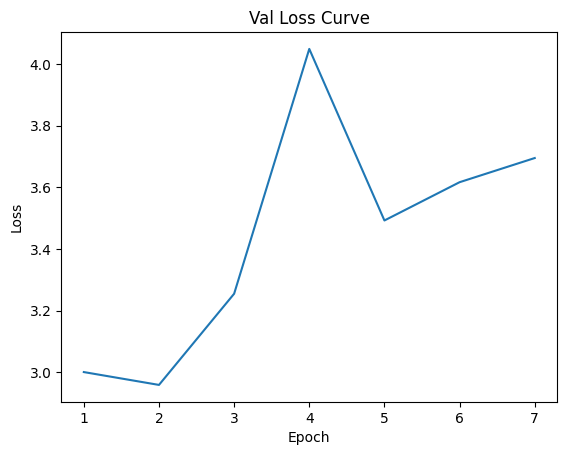

Student weights and architecture saved and exported for lambda: 5


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4469555265763228


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.9094414912602481


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.6245205235831878


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5254143824910417


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5253638303016915


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.525493775439613


100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.48980217251707525


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 1/100*****
*****Train Loss:  0.762483 Val Loss:  1.848626*****
*****Validation Accuracy: 58.96%*****
*****Total Avg Disparity: 0.13537299628453858*****

Class Team_Sports: Recall Difference = 0.08705552636188474
Class Celebration: Recall Difference = -0.07209302325581396
Class Parade: Recall Difference = 0.029087497067792567
Class Waiter_Or_Waitress: Recall Difference = -0.21418439716312065
Class Individual_Sports: Recall Difference = -0.13232087812946403
Class Surgeons: Recall Difference = 0.12967032967032976
Class Spa: Recall Difference = -0.3191489361702127
Class Law_Enforcement: Recall Difference = 0.11518199233716464
Class Business: Recall Difference = 0.03985507246376807
Class Dresses: Recall Difference = -0.5535714285714286
Class Water Activities: Recall Difference = 0.10871928680147869
Class Picnic: Recall Difference = -0.03703703703703709
Class Rescue: Recall Difference = 0.06652697747511788
Class Cheering: Recall Difference = -0.05748772504091651
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.3985131545101895


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 2/100*****
*****Train Loss:  0.256782 Val Loss:  1.859211*****
*****Validation Accuracy: 62.74%*****
*****Total Avg Disparity: 0.14401612245371942*****

Class Team_Sports: Recall Difference = 0.0555146844164186
Class Celebration: Recall Difference = 0.009302325581395265
Class Parade: Recall Difference = 0.07893502228477578
Class Waiter_Or_Waitress: Recall Difference = -0.26595744680851063
Class Individual_Sports: Recall Difference = -0.08965491316442376
Class Surgeons: Recall Difference = -0.04395604395604391
Class Spa: Recall Difference = -0.24113475177304972
Class Law_Enforcement: Recall Difference = 0.11494252873563227
Class Business: Recall Difference = 0.02941176470588236
Class Dresses: Recall Difference = -0.7678571428571428
Class Water Activities: Recall Difference = 0.13687758208306156
Class Picnic: Recall Difference = -0.1481481481481482
Class Rescue: Recall Difference = 0.011000523834468257
Class Cheering: Recall Difference = -0.09410801963993465
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.38859630167922554


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 3/100*****
*****Train Loss: -0.215260 Val Loss:  2.230693*****
*****Validation Accuracy: 61.73%*****
*****Total Avg Disparity: 0.15231904055877196*****

Class Team_Sports: Recall Difference = 0.03985519939277149
Class Celebration: Recall Difference = -0.011627906976744207
Class Parade: Recall Difference = 0.12373915083274689
Class Waiter_Or_Waitress: Recall Difference = -0.22340425531914898
Class Individual_Sports: Recall Difference = -0.1534471092399068
Class Surgeons: Recall Difference = -0.02417582417582409
Class Spa: Recall Difference = -0.3687943262411348
Class Law_Enforcement: Recall Difference = 0.1769636015325669
Class Business: Recall Difference = 0.03069053708439895
Class Dresses: Recall Difference = -0.6547619047619047
Class Water Activities: Recall Difference = 0.18656229615133735
Class Picnic: Recall Difference = -0.03703703703703698
Class Rescue: Recall Difference = 0.16317443687794658
Class Cheering: Recall Difference = -0.05053191489361697
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.38102110782090354


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 4/100*****
*****Train Loss: -0.434671 Val Loss:  2.662032*****
*****Validation Accuracy: 62.45%*****
*****Total Avg Disparity: 0.1323382091005127*****

Class Team_Sports: Recall Difference = 0.004670987329946863
Class Celebration: Recall Difference = 0.02325581395348847
Class Parade: Recall Difference = 0.05665024630541882
Class Waiter_Or_Waitress: Recall Difference = -0.17943262411347516
Class Individual_Sports: Recall Difference = -0.06491993083226821
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = -0.30496453900709225
Class Law_Enforcement: Recall Difference = 0.12236590038314188
Class Business: Recall Difference = 0.00788576300085253
Class Dresses: Recall Difference = -0.7261904761904762
Class Water Activities: Recall Difference = 0.11230702326592734
Class Picnic: Recall Difference = -0.03703703703703709
Class Rescue: Recall Difference = 0.14353064431639612
Class Cheering: Recall Difference = -0.046440261865793864
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.36487538959173593


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 5/100*****
*****Train Loss: -0.544016 Val Loss:  2.651985*****
*****Validation Accuracy: 63.90%*****
*****Total Avg Disparity: 0.15222162614766216*****

Class Team_Sports: Recall Difference = 0.03025632042973081
Class Celebration: Recall Difference = -0.03953488372093028
Class Parade: Recall Difference = 0.12737508796622088
Class Waiter_Or_Waitress: Recall Difference = -0.252482269503546
Class Individual_Sports: Recall Difference = -0.10390196225847681
Class Surgeons: Recall Difference = -0.06080586080586081
Class Spa: Recall Difference = -0.39007092198581567
Class Law_Enforcement: Recall Difference = 0.16690613026819923
Class Business: Recall Difference = 0.013213981244671769
Class Dresses: Recall Difference = -0.7202380952380952
Class Water Activities: Recall Difference = 0.1389432485322898
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.11707700366684132
Class Cheering: Recall Difference = -0.04193944353518825
Class Performance_A

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.33it/s]


Average Adversary epoch loss: 0.3416175175019923


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.34it/s]


*****Epoch 6/100*****
*****Train Loss: -0.245226 Val Loss:  4.835569*****
*****Validation Accuracy: 62.97%*****
*****Total Avg Disparity: 0.13213031345080195*****

Class Team_Sports: Recall Difference = 0.08031762713843638
Class Celebration: Recall Difference = 0.03953488372093017
Class Parade: Recall Difference = 0.11400422237860675
Class Waiter_Or_Waitress: Recall Difference = -0.19007092198581554
Class Individual_Sports: Recall Difference = -0.10371400646567919
Class Surgeons: Recall Difference = -0.04981684981684986
Class Spa: Recall Difference = -0.2624113475177305
Class Law_Enforcement: Recall Difference = 0.14966475095785425
Class Business: Recall Difference = -0.0029838022165388223
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.20602304848880193
Class Picnic: Recall Difference = -0.05555555555555547
Class Rescue: Recall Difference = 0.03038239916186486
Class Cheering: Recall Difference = -0.06873977086743044
Class Performanc

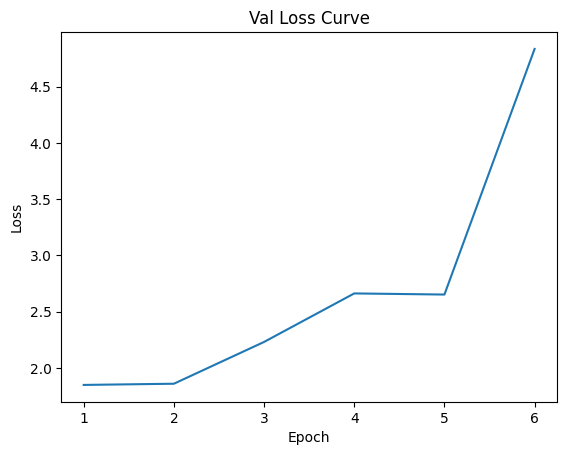

Student weights and architecture saved and exported for lambda: 3


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.446003604461165


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.9096852278008181


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.6167008353068548


100%|█████████████████████████████████████████| 136/136 [01:41<00:00,  1.34it/s]


Average Pretrain Adversary epoch loss:  0.44130100112627535


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4413222821758074


100%|█████████████████████████████████████████| 136/136 [01:42<00:00,  1.33it/s]


Average Pretrain Adversary epoch loss:  0.4412512426428935


100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.3459223035503836


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 1/100*****
*****Train Loss: -0.094375 Val Loss:  0.889487*****
*****Validation Accuracy: 59.80%*****
*****Total Avg Disparity: 0.13850134731893077*****

Class Team_Sports: Recall Difference = 0.12235651310795825
Class Celebration: Recall Difference = -0.02790697674418613
Class Parade: Recall Difference = 0.13769645789350227
Class Waiter_Or_Waitress: Recall Difference = -0.15531914893617027
Class Individual_Sports: Recall Difference = -0.08600857078415158
Class Surgeons: Recall Difference = 0.06153846153846154
Class Spa: Recall Difference = -0.347517730496454
Class Law_Enforcement: Recall Difference = 0.09386973180076619
Class Business: Recall Difference = 0.006606990622335829
Class Dresses: Recall Difference = -0.6309523809523809
Class Water Activities: Recall Difference = 0.08273537725592506
Class Picnic: Recall Difference = -0.11111111111111116
Class Rescue: Recall Difference = 0.05185961236249348
Class Cheering: Recall Difference = 0.03252864157119478
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2961919809527257


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 2/100*****
*****Train Loss: -1.133998 Val Loss:  1.148813*****
*****Validation Accuracy: 62.22%*****
*****Total Avg Disparity: 0.10866094901345266*****

Class Team_Sports: Recall Difference = 0.05029485607520301
Class Celebration: Recall Difference = 0.009302325581395321
Class Parade: Recall Difference = 0.13382594417077176
Class Waiter_Or_Waitress: Recall Difference = -0.20709219858156025
Class Individual_Sports: Recall Difference = -0.12502819336891957
Class Surgeons: Recall Difference = -0.03296703296703296
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.04573754789272033
Class Business: Recall Difference = -0.014066496163682829
Class Dresses: Recall Difference = -0.5440476190476191
Class Water Activities: Recall Difference = 0.0899108501848227
Class Picnic: Recall Difference = 0.14814814814814803
Class Rescue: Recall Difference = 0.00864326872708221
Class Cheering: Recall Difference = 0.017798690671031125
Class Performanc

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2906153783859575


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 3/100*****
*****Train Loss: -1.780468 Val Loss:  2.008159*****
*****Validation Accuracy: 61.96%*****
*****Total Avg Disparity: 0.11713688182979924*****

Class Team_Sports: Recall Difference = 0.057534886436620525
Class Celebration: Recall Difference = -0.0976744186046512
Class Parade: Recall Difference = 0.11400422237860663
Class Waiter_Or_Waitress: Recall Difference = -0.21560283687943266
Class Individual_Sports: Recall Difference = -0.07209984211713405
Class Surgeons: Recall Difference = 0.08131868131868125
Class Spa: Recall Difference = -0.014184397163120477
Class Law_Enforcement: Recall Difference = 0.08429118773946365
Class Business: Recall Difference = 0.009803921568627416
Class Dresses: Recall Difference = -0.5892857142857143
Class Water Activities: Recall Difference = 0.06686236138290935
Class Picnic: Recall Difference = -0.14814814814814814
Class Rescue: Recall Difference = 0.2016762702985856
Class Cheering: Recall Difference = 0.004705400981996677
Class Performance

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.27271723812993837


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 4/100*****
*****Train Loss: -1.798137 Val Loss:  2.378886*****
*****Validation Accuracy: 62.11%*****
*****Total Avg Disparity: 0.13298961413934055*****

Class Team_Sports: Recall Difference = 0.1144975769253227
Class Celebration: Recall Difference = -0.0488372093023256
Class Parade: Recall Difference = 0.06673703964344357
Class Waiter_Or_Waitress: Recall Difference = -0.18723404255319143
Class Individual_Sports: Recall Difference = -0.12848657995639434
Class Surgeons: Recall Difference = 0.07838827838827839
Class Spa: Recall Difference = 0.07092198581560283
Class Law_Enforcement: Recall Difference = 0.11135057471264398
Class Business: Recall Difference = 0.10443307757885761
Class Dresses: Recall Difference = -0.7797619047619048
Class Water Activities: Recall Difference = 0.0625135899108501
Class Picnic: Recall Difference = 0.01851851851851849
Class Rescue: Recall Difference = 0.0762179151388161
Class Cheering: Recall Difference = 0.00716039279869074
Class Performance_And_Ent

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.26013251909000035


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 5/100*****
*****Train Loss: -1.896263 Val Loss:  2.274071*****
*****Validation Accuracy: 63.75%*****
*****Total Avg Disparity: 0.1181957891107567*****

Class Team_Sports: Recall Difference = 0.04911543177439137
Class Celebration: Recall Difference = -0.08837209302325577
Class Parade: Recall Difference = 0.1280788177339902
Class Waiter_Or_Waitress: Recall Difference = -0.2191489361702128
Class Individual_Sports: Recall Difference = -0.0860085707841517
Class Surgeons: Recall Difference = -0.049816849816849806
Class Spa: Recall Difference = -0.05673758865248235
Class Law_Enforcement: Recall Difference = 0.014367816091954033
Class Business: Recall Difference = 0.0415601023017903
Class Dresses: Recall Difference = -0.6845238095238095
Class Water Activities: Recall Difference = 0.10437051532941943
Class Picnic: Recall Difference = 0.01851851851851838
Class Rescue: Recall Difference = 0.030120481927710885
Class Cheering: Recall Difference = 0.019435351882160334
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.2645456463317661


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.29it/s]


*****Epoch 6/100*****
*****Train Loss: -1.949933 Val Loss:  2.210435*****
*****Validation Accuracy: 64.13%*****
*****Total Avg Disparity: 0.12391904564848794*****

Class Team_Sports: Recall Difference = 0.023074677409937405
Class Celebration: Recall Difference = -0.11860465116279062
Class Parade: Recall Difference = 0.08339197748064742
Class Waiter_Or_Waitress: Recall Difference = -0.3312056737588651
Class Individual_Sports: Recall Difference = -0.15322156228854988
Class Surgeons: Recall Difference = -0.024175824175824145
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.0941091954022989
Class Business: Recall Difference = 0.05797101449275355
Class Dresses: Recall Difference = -0.6369047619047619
Class Water Activities: Recall Difference = 0.020004348771472058
Class Picnic: Recall Difference = -0.0185185185185186
Class Rescue: Recall Difference = 0.1388161341016239
Class Cheering: Recall Difference = -0.0824468085106384
Class Performance_A

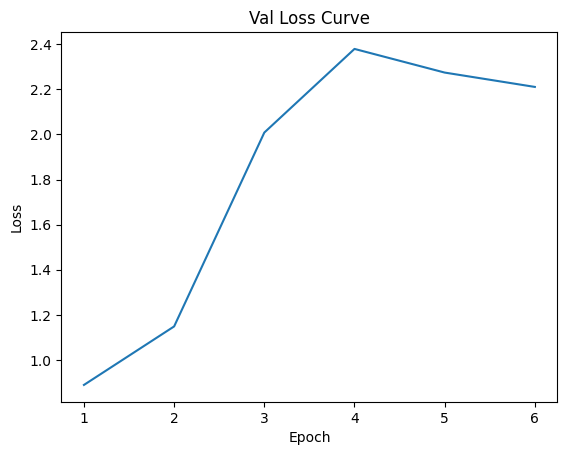

Student weights and architecture saved and exported for lambda: 10


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 0: loss - 1.4361808804028176


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 1: loss - 0.9084531616638688


100%|█████████████████████████████████████████| 136/136 [01:23<00:00,  1.63it/s]


*******Epoch 2: loss - 0.6208374138702365


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5185965726919034


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.518673559102942


100%|█████████████████████████████████████████| 136/136 [01:40<00:00,  1.35it/s]


Average Pretrain Adversary epoch loss:  0.5186894919504138


100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.34it/s]


Average Adversary epoch loss: 0.5226493909516755


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 1/100*****
*****Train Loss:  1.694124 Val Loss:  2.474010*****
*****Validation Accuracy: 60.84%*****
*****Total Avg Disparity: 0.1436022922049628*****

Class Team_Sports: Recall Difference = 0.07527296082209367
Class Celebration: Recall Difference = 0.009302325581395321
Class Parade: Recall Difference = 0.1357025568848228
Class Waiter_Or_Waitress: Recall Difference = -0.26453900709219846
Class Individual_Sports: Recall Difference = -0.12833621532215633
Class Surgeons: Recall Difference = 0.0388278388278388
Class Spa: Recall Difference = -0.07801418439716312
Class Law_Enforcement: Recall Difference = 0.1484674329501916
Class Business: Recall Difference = -0.02280477408354642
Class Dresses: Recall Difference = -0.7440476190476191
Class Water Activities: Recall Difference = 0.05892585344640133
Class Picnic: Recall Difference = -0.18518518518518517
Class Rescue: Recall Difference = 0.0667888947092719
Class Cheering: Recall Difference = -0.11886252045826523
Class Performance_And_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.4773871168932494


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.26it/s]


*****Epoch 2/100*****
*****Train Loss:  1.310939 Val Loss:  3.045381*****
*****Validation Accuracy: 62.57%*****
*****Total Avg Disparity: 0.11898816855863957*****

Class Team_Sports: Recall Difference = 0.036433701173585575
Class Celebration: Recall Difference = -0.03488372093023262
Class Parade: Recall Difference = 0.10250996950504354
Class Waiter_Or_Waitress: Recall Difference = -0.13546099290780134
Class Individual_Sports: Recall Difference = -0.10747312232163009
Class Surgeons: Recall Difference = 0.05567765567765559
Class Spa: Recall Difference = 0.11347517730496448
Class Law_Enforcement: Recall Difference = 0.12236590038314177
Class Business: Recall Difference = -0.11956521739130432
Class Dresses: Recall Difference = -0.4607142857142857
Class Water Activities: Recall Difference = 0.11883018047401606
Class Picnic: Recall Difference = 0.05555555555555547
Class Rescue: Recall Difference = 0.09298061812467256
Class Cheering: Recall Difference = -0.07978723404255317
Class Performance_

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.29it/s]


Average Adversary epoch loss: 0.33522769041797695


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 3/100*****
*****Train Loss:  1.076463 Val Loss:  4.052700*****
*****Validation Accuracy: 62.54%*****
*****Total Avg Disparity: 0.1515346862047973*****

Class Team_Sports: Recall Difference = 0.027173468791966027
Class Celebration: Recall Difference = -0.044186046511627886
Class Parade: Recall Difference = 0.11400422237860663
Class Waiter_Or_Waitress: Recall Difference = -0.2737588652482269
Class Individual_Sports: Recall Difference = -0.12874971806631086
Class Surgeons: Recall Difference = 0.14432234432234436
Class Spa: Recall Difference = -0.099290780141844
Class Law_Enforcement: Recall Difference = 0.17337164750957856
Class Business: Recall Difference = 0.025362318840579823
Class Dresses: Recall Difference = -0.4666666666666666
Class Water Activities: Recall Difference = 0.1454664057403784
Class Picnic: Recall Difference = -0.2592592592592593
Class Rescue: Recall Difference = -0.006024096385542188
Class Cheering: Recall Difference = -0.1415711947626841
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.28it/s]


Average Adversary epoch loss: 0.2777422239236972


100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 4/100*****
*****Train Loss:  0.933307 Val Loss:  4.768011*****
*****Validation Accuracy: 62.91%*****
*****Total Avg Disparity: 0.13458546854099593*****

Class Team_Sports: Recall Difference = 0.08233782915863852
Class Celebration: Recall Difference = -0.046511627906976605
Class Parade: Recall Difference = 0.002228477597935652
Class Waiter_Or_Waitress: Recall Difference = -0.23120567375886514
Class Individual_Sports: Recall Difference = -0.0755206375460491
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.15660919540229867
Class Business: Recall Difference = 0.038363171355498604
Class Dresses: Recall Difference = -0.7083333333333333
Class Water Activities: Recall Difference = 0.021417699499891363
Class Picnic: Recall Difference = -0.33333333333333337
Class Rescue: Recall Difference = 0.16291251964379255
Class Cheering: Recall Difference = -0.020049099836333906
Class Perfo

100%|█████████████████████████████████████████| 136/136 [00:58<00:00,  2.31it/s]


Average Adversary epoch loss: 0.2457897050634903


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 5/100*****
*****Train Loss:  0.850124 Val Loss:  5.208225*****
*****Validation Accuracy: 63.41%*****
*****Total Avg Disparity: 0.15198158917913437*****

Class Team_Sports: Recall Difference = 0.0930577450808665
Class Celebration: Recall Difference = 0.009302325581395432
Class Parade: Recall Difference = 0.1581046211588084
Class Waiter_Or_Waitress: Recall Difference = -0.2843971631205675
Class Individual_Sports: Recall Difference = -0.12852417111495384
Class Surgeons: Recall Difference = 0.00146520146520146
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.1872605363984673
Class Business: Recall Difference = 0.0002131287297527651
Class Dresses: Recall Difference = -0.7857142857142858
Class Water Activities: Recall Difference = 0.11013263752989777
Class Picnic: Recall Difference = -0.33333333333333337
Class Rescue: Recall Difference = 0.06888423258250392
Class Cheering: Recall Difference = 0.011865793780687417
Class Performance_An

100%|█████████████████████████████████████████| 136/136 [00:59<00:00,  2.30it/s]


Average Adversary epoch loss: 0.22186408279573216


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.35it/s]


*****Epoch 6/100*****
*****Train Loss:  0.687005 Val Loss:  5.223431*****
*****Validation Accuracy: 64.56%*****
*****Total Avg Disparity: 0.1523715096271036*****

Class Team_Sports: Recall Difference = 0.07251707829742515
Class Celebration: Recall Difference = -0.07906976744186056
Class Parade: Recall Difference = 0.13628899835796393
Class Waiter_Or_Waitress: Recall Difference = -0.2950354609929078
Class Individual_Sports: Recall Difference = -0.10021802871964514
Class Surgeons: Recall Difference = 0.0073260073260072445
Class Spa: Recall Difference = 0.13475177304964536
Class Law_Enforcement: Recall Difference = 0.20450191570881227
Class Business: Recall Difference = -0.03367433930093788
Class Dresses: Recall Difference = -0.6428571428571429
Class Water Activities: Recall Difference = 0.18297455968688836
Class Picnic: Recall Difference = -0.22222222222222227
Class Rescue: Recall Difference = 0.11707700366684132
Class Cheering: Recall Difference = 0.06648936170212766
Class Performance_A

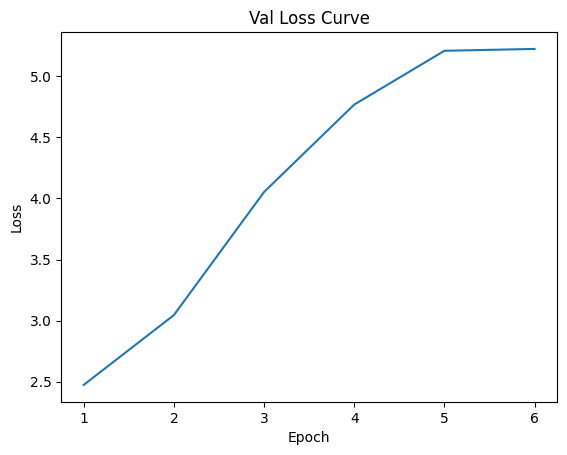

Student weights and architecture saved and exported for lambda: 0.5


100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 1/100*****
*****Train Loss:  1.451259 Val Loss:  0.618013*****
*****Validation Accuracy: 58.70%*****
*****Total Avg Disparity: 0.1447190443777621*****

Class Team_Sports: Recall Difference = 0.03531266421439838
Class Celebration: Recall Difference = 0.018604651162790697
Class Parade: Recall Difference = 0.10192352803190252
Class Waiter_Or_Waitress: Recall Difference = -0.22056737588652464
Class Individual_Sports: Recall Difference = -0.2064506428088113
Class Surgeons: Recall Difference = 0.032967032967032905
Class Spa: Recall Difference = 0.03546099290780136
Class Law_Enforcement: Recall Difference = 0.2456896551724138
Class Business: Recall Difference = 0.09441602728047738
Class Dresses: Recall Difference = -0.875
Class Water Activities: Recall Difference = 0.08414872798434425
Class Picnic: Recall Difference = -0.09259259259259267
Class Rescue: Recall Difference = -0.007857517024620175
Class Cheering: Recall Difference = -0.011456628477905073
Class Performance_And_Entertain

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.30it/s]


*****Epoch 2/100*****
*****Train Loss:  0.892234 Val Loss:  0.608986*****
*****Validation Accuracy: 62.05%*****
*****Total Avg Disparity: 0.1423182823094146*****

Class Team_Sports: Recall Difference = 0.010392946809131831
Class Celebration: Recall Difference = -0.15581395348837213
Class Parade: Recall Difference = 0.13757916959887395
Class Waiter_Or_Waitress: Recall Difference = -0.24184397163120552
Class Individual_Sports: Recall Difference = -0.1252537403202767
Class Surgeons: Recall Difference = 0.038827838827838856
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.19109195402298862
Class Business: Recall Difference = 0.02408354646206301
Class Dresses: Recall Difference = -0.761904761904762
Class Water Activities: Recall Difference = 0.08773646444879335
Class Picnic: Recall Difference = -0.12962962962962965
Class Rescue: Recall Difference = 0.0450497642744892
Class Cheering: Recall Difference = -0.09513093289689029
Class Performance_An

100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.28it/s]


*****Epoch 3/100*****
*****Train Loss:  0.611212 Val Loss:  0.668418*****
*****Validation Accuracy: 62.80%*****
*****Total Avg Disparity: 0.1548519855686821*****

Class Team_Sports: Recall Difference = 0.05107724645296885
Class Celebration: Recall Difference = 0.01860465116279081
Class Parade: Recall Difference = 0.10309641097818434
Class Waiter_Or_Waitress: Recall Difference = -0.3099290780141845
Class Individual_Sports: Recall Difference = -0.21370573641079604
Class Surgeons: Recall Difference = 0.027106227106227065
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.11542145593869713
Class Business: Recall Difference = -0.10123614663256608
Class Dresses: Recall Difference = -0.7797619047619048
Class Water Activities: Recall Difference = 0.06468797564687956
Class Picnic: Recall Difference = -0.27777777777777773
Class Rescue: Recall Difference = 0.0955997904662127
Class Cheering: Recall Difference = -0.049509001636661165
Class Performance_A

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.33it/s]


*****Epoch 4/100*****
*****Train Loss:  0.425035 Val Loss:  0.740626*****
*****Validation Accuracy: 63.67%*****
*****Total Avg Disparity: 0.13354784850699725*****

Class Team_Sports: Recall Difference = -0.010766625795527451
Class Celebration: Recall Difference = -0.023255813953488524
Class Parade: Recall Difference = 0.127375087966221
Class Waiter_Or_Waitress: Recall Difference = -0.2900709219858157
Class Individual_Sports: Recall Difference = -0.15006390496955124
Class Surgeons: Recall Difference = -0.04981684981684986
Class Spa: Recall Difference = -0.014184397163120699
Class Law_Enforcement: Recall Difference = 0.18055555555555558
Class Business: Recall Difference = 0.00660699062233594
Class Dresses: Recall Difference = -0.6249999999999999
Class Water Activities: Recall Difference = 0.10219612959338986
Class Picnic: Recall Difference = -0.20370370370370383
Class Rescue: Recall Difference = 0.059193294918805706
Class Cheering: Recall Difference = -0.027209492635024535
Class Performa

100%|███████████████████████████████████████████| 46/46 [00:20<00:00,  2.27it/s]


*****Epoch 5/100*****
*****Train Loss:  0.286806 Val Loss:  0.817293*****
*****Validation Accuracy: 63.92%*****
*****Total Avg Disparity: 0.12512010665272177*****

Class Team_Sports: Recall Difference = 0.058936182635604406
Class Celebration: Recall Difference = -0.020930232558139583
Class Parade: Recall Difference = 0.05207600281491909
Class Waiter_Or_Waitress: Recall Difference = -0.25248226950354613
Class Individual_Sports: Recall Difference = -0.0685662732125405
Class Surgeons: Recall Difference = 0.11282051282051275
Class Spa: Recall Difference = 0.049645390070921946
Class Law_Enforcement: Recall Difference = 0.10847701149425304
Class Business: Recall Difference = 0.0415601023017903
Class Dresses: Recall Difference = -0.6964285714285714
Class Water Activities: Recall Difference = 0.07338551859099807
Class Picnic: Recall Difference = -0.14814814814814825
Class Rescue: Recall Difference = 0.059193294918805706
Class Cheering: Recall Difference = -0.07937806873977082
Class Performance

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.31it/s]


*****Epoch 6/100*****
*****Train Loss:  0.211052 Val Loss:  0.830929*****
*****Validation Accuracy: 64.50%*****
*****Total Avg Disparity: 0.10869814687941107*****

Class Team_Sports: Recall Difference = 0.022736030828516385
Class Celebration: Recall Difference = -0.06511627906976747
Class Parade: Recall Difference = 0.05641566971616219
Class Waiter_Or_Waitress: Recall Difference = -0.22056737588652497
Class Individual_Sports: Recall Difference = -0.17818209157206222
Class Surgeons: Recall Difference = 0.0073260073260073
Class Spa: Recall Difference = 0.13475177304964547
Class Law_Enforcement: Recall Difference = 0.05938697318007646
Class Business: Recall Difference = 0.02195225916453547
Class Dresses: Recall Difference = -0.6428571428571429
Class Water Activities: Recall Difference = 0.15557729941291576
Class Picnic: Recall Difference = -0.07407407407407418
Class Rescue: Recall Difference = 0.03509690937663701
Class Cheering: Recall Difference = -0.011456628477905129
Class Performance_

100%|███████████████████████████████████████████| 46/46 [00:19<00:00,  2.32it/s]


*****Epoch 7/100*****
*****Train Loss:  0.171401 Val Loss:  0.795543*****
*****Validation Accuracy: 63.81%*****
*****Total Avg Disparity: 0.12176805697259878*****

Class Team_Sports: Recall Difference = 0.009493781748116992
Class Celebration: Recall Difference = -0.03023255813953496
Class Parade: Recall Difference = 0.18109312690593482
Class Waiter_Or_Waitress: Recall Difference = -0.21276595744680848
Class Individual_Sports: Recall Difference = -0.06127358845199615
Class Surgeons: Recall Difference = -0.05274725274725278
Class Spa: Recall Difference = -0.03546099290780147
Class Law_Enforcement: Recall Difference = 0.1630747126436783
Class Business: Recall Difference = 0.012148337595907943
Class Dresses: Recall Difference = -0.6666666666666666
Class Water Activities: Recall Difference = 0.11806914546640568
Class Picnic: Recall Difference = 0.09259259259259256
Class Rescue: Recall Difference = 0.1293871136720796
Class Cheering: Recall Difference = -0.02373158756137478
Class Performance_

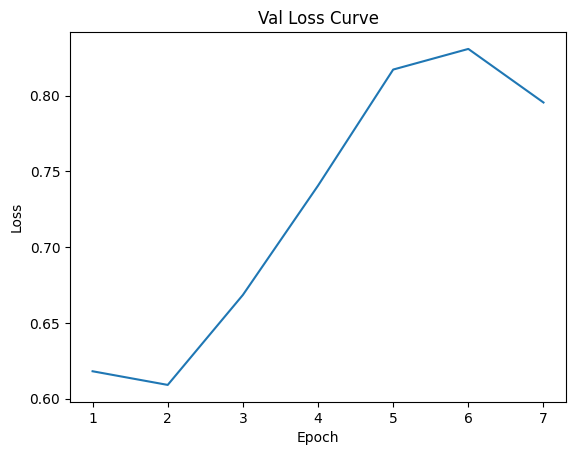

Student weights and architecture saved and exported for lambda: 0


In [23]:
lambda_results = {}
# Loop for training the student model with different lambda values
for i in lmda_list_student:
    # load teacher model with lambda 0
    teacher_model = torch.load('teacher_model_ckd_wider_lambda02.pth')
    teacher_model.load_state_dict(torch.load('teacher_model_weights_ckd_wider_lambda02.pth'))
    
    # Reset the student model for each lambda
    student_model = torchvision.models.efficientnet_b0(weights='DEFAULT')
    student_model.classifier = nn.Linear(1280, num_classes)
    student_optimizer = optim.Adam(student_model.parameters(), lr=learning_rate)

    adv = Adversary()
    student_optimizer_adv = optim.Adam(adv.parameters(), lr=learning_rate)
    
    if i != 0:
        pretrain_student(student_model, teacher_model, trainloader, criterion_clf, student_optimizer, device, alpha, temperature, epochs_pretrain)
        pretrain_adversary(adv, teacher_model, optimizer_adv, trainloader, adv_criterion, device, epochs_pretrain)
    
    student_mean_abs_val_disparity = train_student_with_distillation_disparity(student_model, teacher_model, adv, trainloader, testloader, criterion_clf, adv_criterion, student_optimizer, device, alpha, temperature, epochs, lmda=i, patience=patience_student, optimizer_adv=student_optimizer_adv)

    torch.save(student_model.state_dict(), f'student_model_weights_ckd_wider_lambda{i}.pth')
    torch.save(student_model, f'student_model_ckd_wider_lambda{i}.pth')
    print('Student weights and architecture saved and exported for lambda:', i)

    # Update the dictionary with the student results
    if i in lambda_results:
        # If the key 'i' is already present in the dictionary
        lambda_results[i].update({
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        })
    else:
        # If the key 'i' is not present in the dictionary
        lambda_results[i] = {
            'student_mean_abs_val_disparity': student_mean_abs_val_disparity
        }

In [24]:
def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for batch in dataloader:
        inputs = batch['img'].to(device)
        labels = batch['label'].to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher(inputs)
            student_outputs = student(inputs)
            
        teacher_preds = torch.argmax(teacher_outputs, dim=1).cpu().numpy()
        student_preds = torch.argmax(student_outputs, dim=1).cpu().numpy()
        
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(teacher_preds)
        all_student_preds.append(student_preds)

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return {
        'metrics': metrics,
        'all_labels': all_labels,
        'all_teacher_preds': all_teacher_preds,
        'all_student_preds': all_student_preds
    }

def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    dataiter = iter(dataloader)
    data = next(dataiter)
    inputs = data['img']
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

In [25]:
# Loop through each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models for the current lambda
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Compute performance metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)

    # Compute model sizes and inference times
    teacher_params, student_params = compare_model_size(teacher_model, student_model)
    teacher_time, student_time = compare_inference_time(teacher_model, student_model, testloader)

    # Update results for the current lambda value
    if lmda in lambda_results:
        lambda_results[lmda].update({
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        })
    else:
        lambda_results[lmda] = {
            'performance_metrics': performance_metrics,
            'teacher_params': teacher_params,
            'student_params': student_params,
            'teacher_time': teacher_time,
            'student_time': student_time
        }


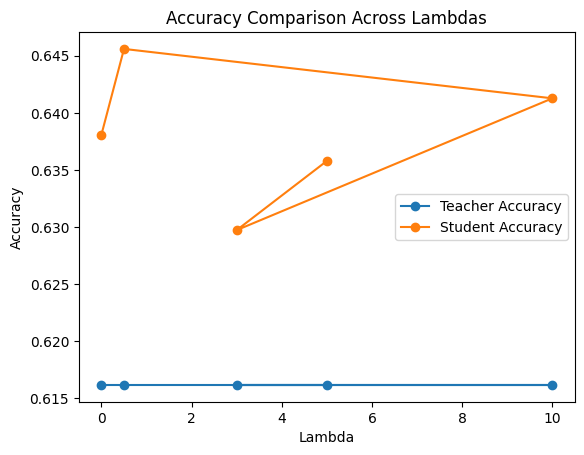

In [26]:
lambdas = list(lambda_results.keys())
teacher_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][0] for lmda in lambdas]
student_accuracies = [lambda_results[lmda]['performance_metrics']['metrics']['accuracy'][1] for lmda in lambdas]

plt.plot(lambdas, teacher_accuracies, label='Teacher Accuracy', marker='o')
plt.plot(lambdas, student_accuracies, label='Student Accuracy', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison Across Lambdas')
plt.legend()
plt.show()


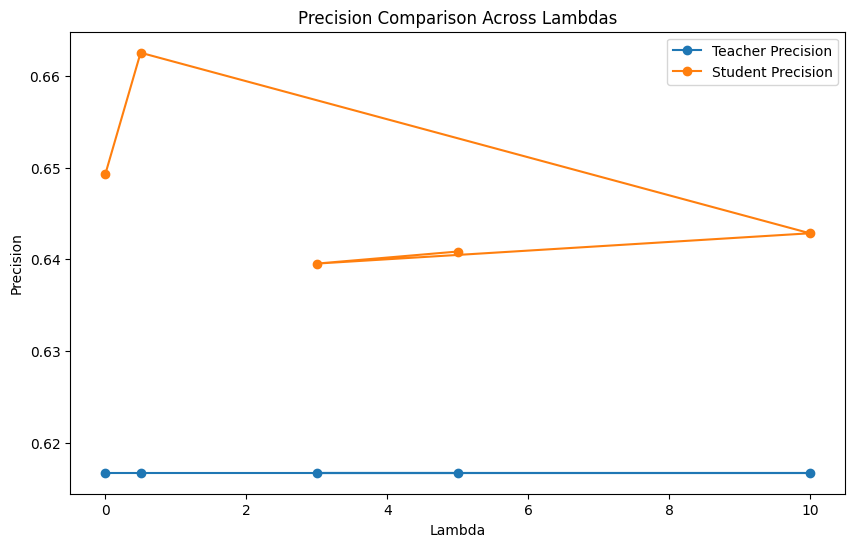

In [27]:
# Precision
teacher_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][0] for lmda in lambdas]
student_precisions = [lambda_results[lmda]['performance_metrics']['metrics']['precision'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_precisions, label='Teacher Precision', marker='o')
plt.plot(lambdas, student_precisions, label='Student Precision', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Precision')
plt.title('Precision Comparison Across Lambdas')
plt.legend()
plt.show()


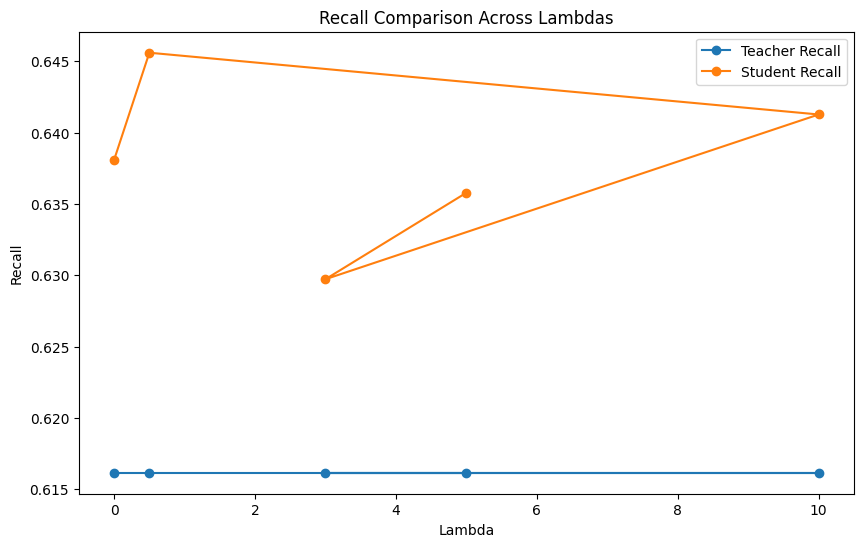

In [28]:
# Recall
teacher_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][0] for lmda in lambdas]
student_recalls = [lambda_results[lmda]['performance_metrics']['metrics']['recall'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_recalls, label='Teacher Recall', marker='o')
plt.plot(lambdas, student_recalls, label='Student Recall', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Recall')
plt.title('Recall Comparison Across Lambdas')
plt.legend()
plt.show()


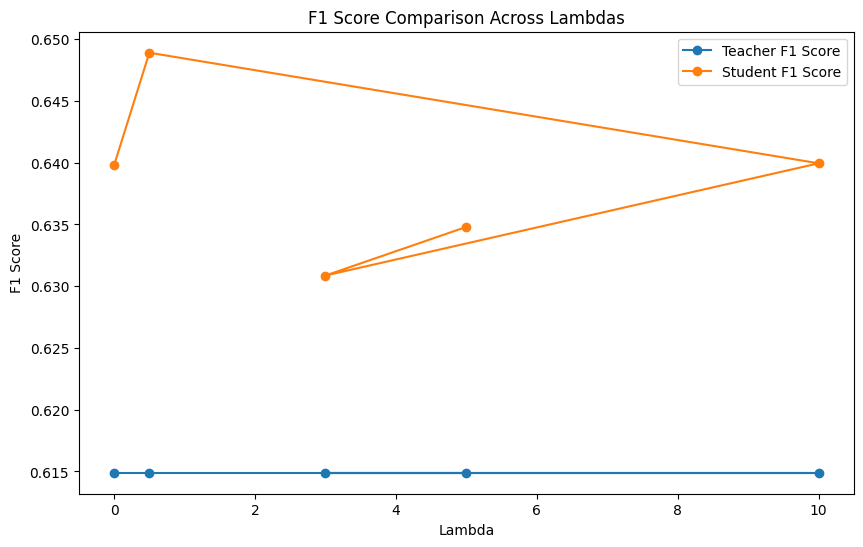

In [29]:
# F1 Score
teacher_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][0] for lmda in lambdas]
student_f1s = [lambda_results[lmda]['performance_metrics']['metrics']['f1'][1] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_f1s, label='Teacher F1 Score', marker='o')
plt.plot(lambdas, student_f1s, label='Student F1 Score', marker='o')
plt.xlabel('Lambda')
plt.ylabel('F1 Score')
plt.title('F1 Score Comparison Across Lambdas')
plt.legend()
plt.show()


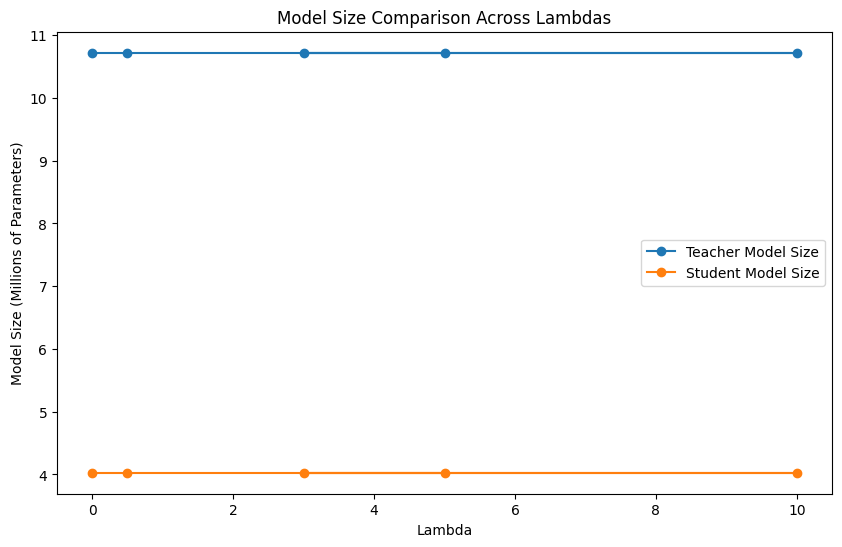

In [30]:
# Model Size
teacher_sizes = [lambda_results[lmda]['teacher_params'] / 1e6 for lmda in lambdas]  # Convert to millions
student_sizes = [lambda_results[lmda]['student_params'] / 1e6 for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_sizes, label='Teacher Model Size', marker='o')
plt.plot(lambdas, student_sizes, label='Student Model Size', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Model Size (Millions of Parameters)')
plt.title('Model Size Comparison Across Lambdas')
plt.legend()
plt.show()


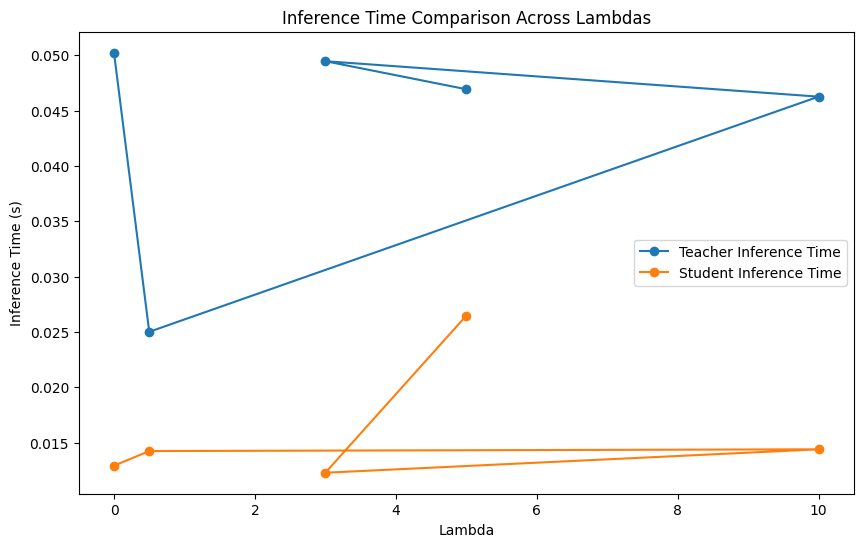

In [31]:
# Inference Time
teacher_times = [lambda_results[lmda]['teacher_time'] for lmda in lambdas]
student_times = [lambda_results[lmda]['student_time'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, teacher_times, label='Teacher Inference Time', marker='o')
plt.plot(lambdas, student_times, label='Student Inference Time', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Inference Time (s)')
plt.title('Inference Time Comparison Across Lambdas')
plt.legend()
plt.show()


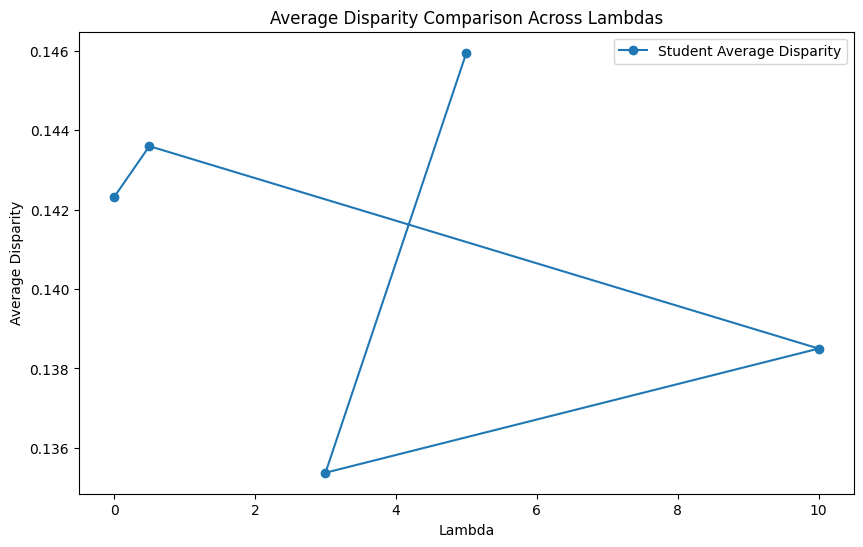

In [32]:
# Extracting disparity values for both teacher and student models
student_disparities = [lambda_results[lmda]['student_mean_abs_val_disparity'] for lmda in lambdas]

plt.figure(figsize=(10, 6))
plt.plot(lambdas, student_disparities, label='Student Average Disparity', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Average Disparity')
plt.title('Average Disparity Comparison Across Lambdas')
plt.legend()
plt.show()


In [33]:
lambda_results

{5: {'student_mean_abs_val_disparity': 0.1459562811502919,
  'performance_metrics': {'metrics': {'accuracy': (0.6161616161616161,
     0.6357864357864358),
    'precision': (0.6167080681738965, 0.64083444991108),
    'recall': (0.6161616161616161, 0.6357864357864358),
    'f1': (0.6148997785968799, 0.634798878370958)},
   'all_labels': array([ 2,  2,  2, ..., 13, 13, 13]),
   'all_teacher_preds': array([ 2,  8,  2, ..., 15,  1,  8]),
   'all_student_preds': array([ 2, 13,  2, ..., 15,  0,  3])},
  'teacher_params': 10720824,
  'student_params': 4028044,
  'teacher_time': 0.04693484306335449,
  'student_time': 0.026477813720703125},
 3: {'student_mean_abs_val_disparity': 0.13537299628453858,
  'performance_metrics': {'metrics': {'accuracy': (0.6161616161616161,
     0.6297258297258297),
    'precision': (0.6167080681738965, 0.6395182227206722),
    'recall': (0.6161616161616161, 0.6297258297258297),
    'f1': (0.6148997785968799, 0.6308628085131893)},
   'all_labels': array([ 2,  2,  2,

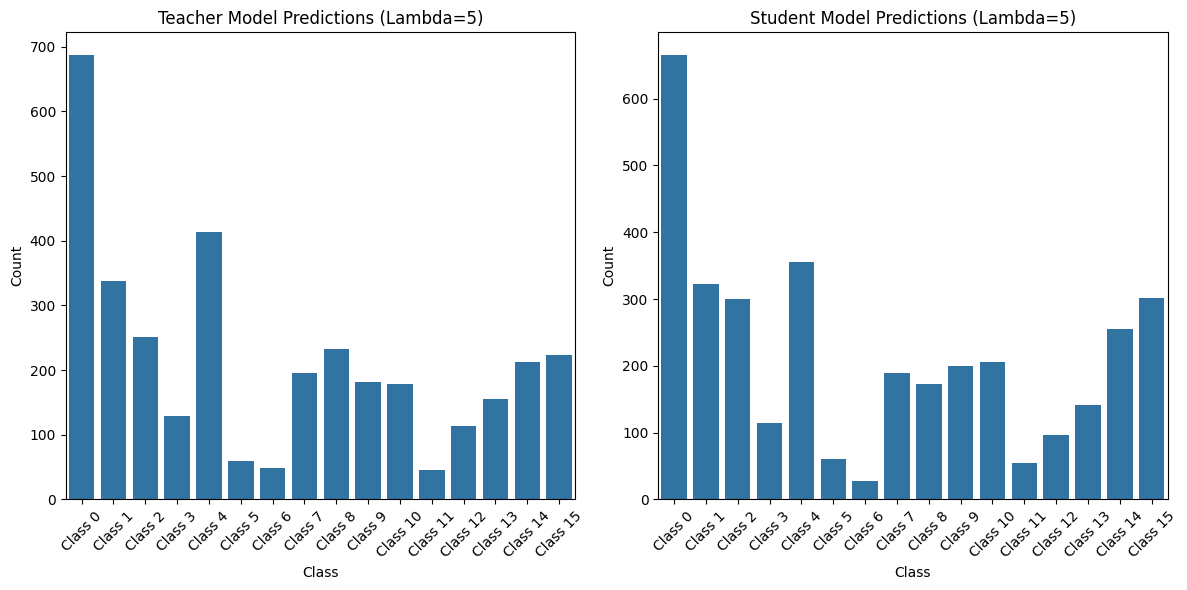

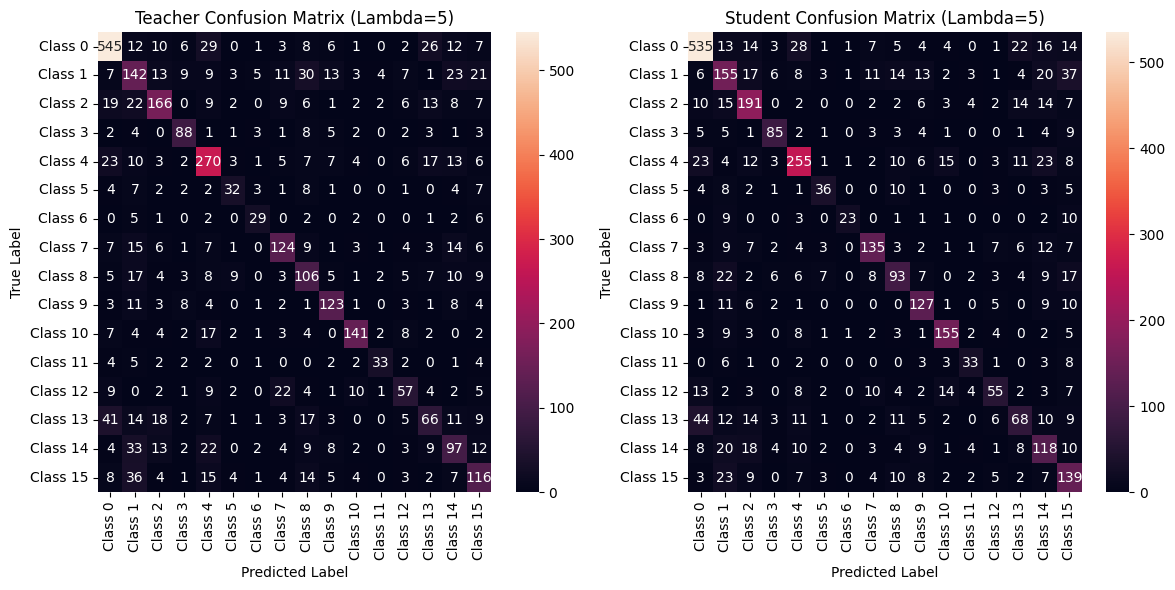

Classification Report - Teacher Model (Lambda=5)
              precision    recall  f1-score   support

     Class 0       0.79      0.82      0.80       668
     Class 1       0.42      0.47      0.45       301
     Class 2       0.66      0.61      0.63       272
     Class 3       0.68      0.71      0.70       124
     Class 4       0.65      0.72      0.68       377
     Class 5       0.53      0.43      0.48        74
     Class 6       0.59      0.58      0.59        50
     Class 7       0.64      0.61      0.62       202
     Class 8       0.45      0.55      0.50       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.71      0.75       199
    Class 11       0.73      0.55      0.63        60
    Class 12       0.50      0.44      0.47       129
    Class 13       0.43      0.33      0.37       198
    Class 14       0.46      0.44      0.45       220
    Class 15       0.52      0.52      0.52       224

    accuracy                   

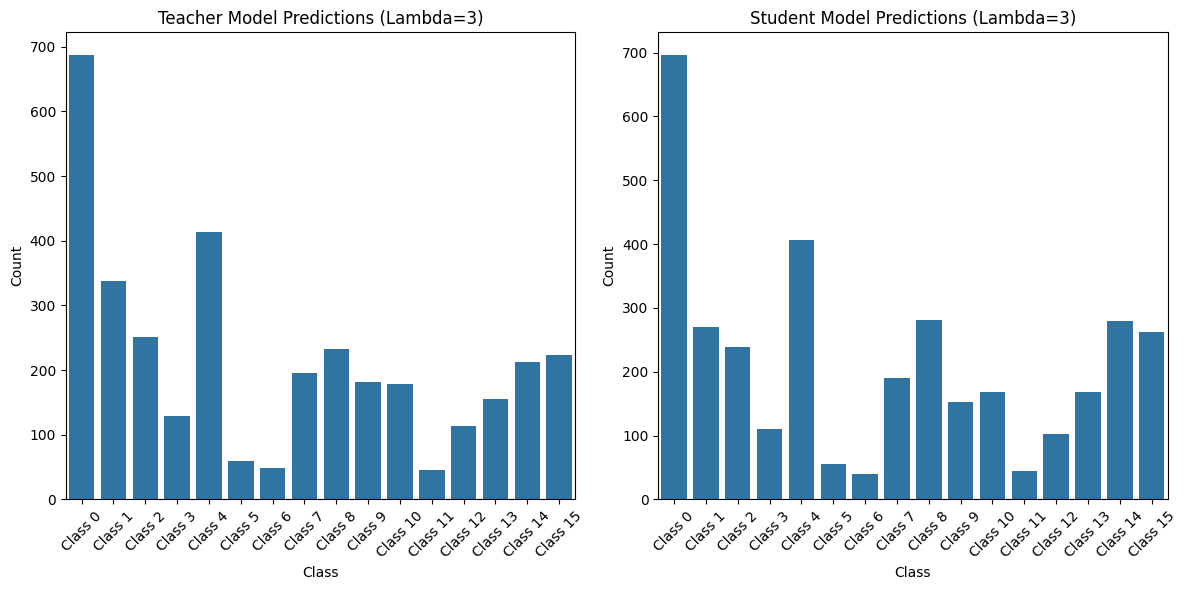

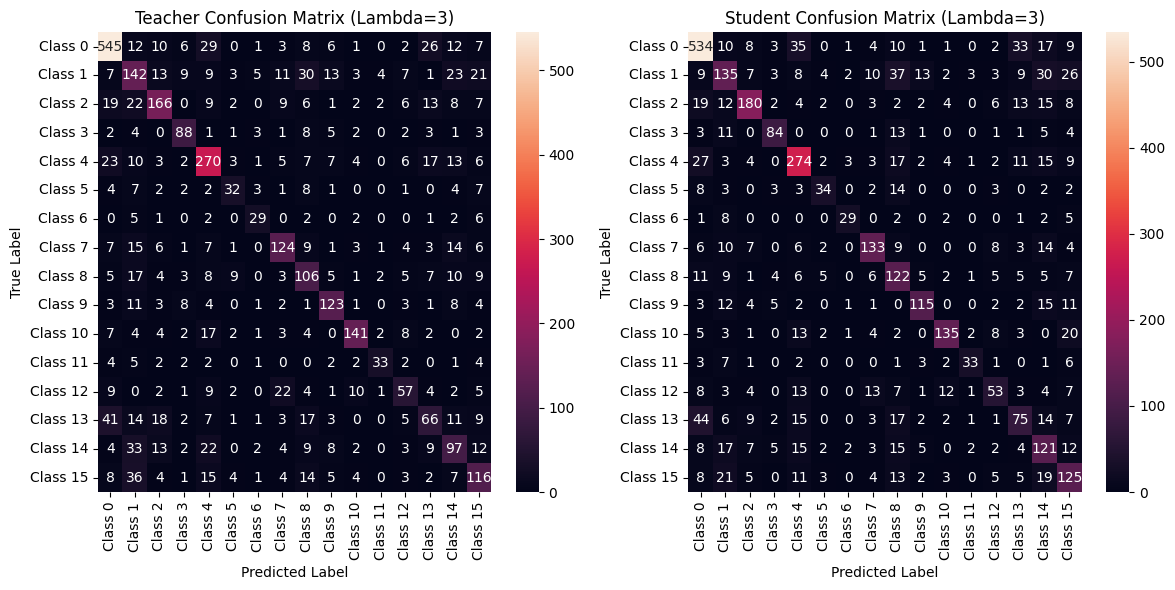

Classification Report - Teacher Model (Lambda=3)
              precision    recall  f1-score   support

     Class 0       0.79      0.82      0.80       668
     Class 1       0.42      0.47      0.45       301
     Class 2       0.66      0.61      0.63       272
     Class 3       0.68      0.71      0.70       124
     Class 4       0.65      0.72      0.68       377
     Class 5       0.53      0.43      0.48        74
     Class 6       0.59      0.58      0.59        50
     Class 7       0.64      0.61      0.62       202
     Class 8       0.45      0.55      0.50       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.71      0.75       199
    Class 11       0.73      0.55      0.63        60
    Class 12       0.50      0.44      0.47       129
    Class 13       0.43      0.33      0.37       198
    Class 14       0.46      0.44      0.45       220
    Class 15       0.52      0.52      0.52       224

    accuracy                   

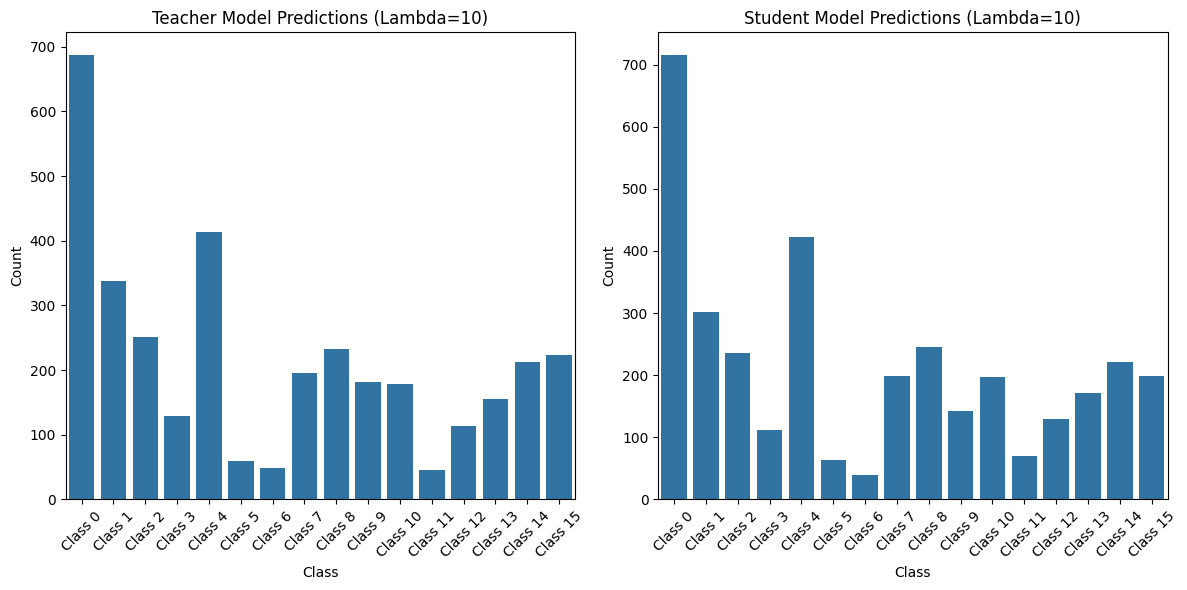

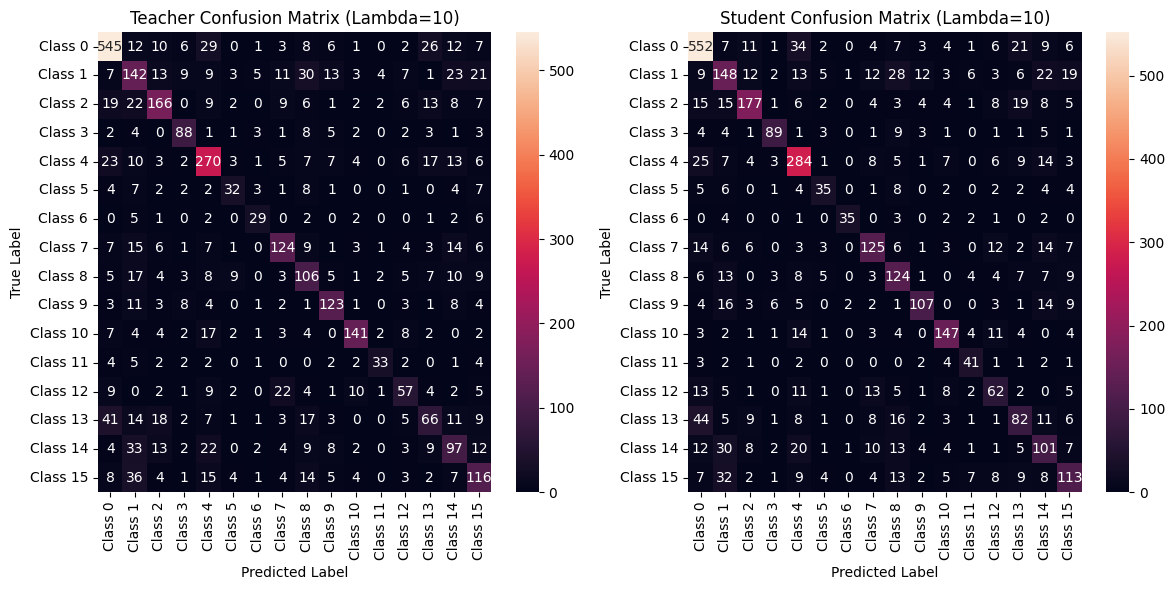

Classification Report - Teacher Model (Lambda=10)
              precision    recall  f1-score   support

     Class 0       0.79      0.82      0.80       668
     Class 1       0.42      0.47      0.45       301
     Class 2       0.66      0.61      0.63       272
     Class 3       0.68      0.71      0.70       124
     Class 4       0.65      0.72      0.68       377
     Class 5       0.53      0.43      0.48        74
     Class 6       0.59      0.58      0.59        50
     Class 7       0.64      0.61      0.62       202
     Class 8       0.45      0.55      0.50       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.71      0.75       199
    Class 11       0.73      0.55      0.63        60
    Class 12       0.50      0.44      0.47       129
    Class 13       0.43      0.33      0.37       198
    Class 14       0.46      0.44      0.45       220
    Class 15       0.52      0.52      0.52       224

    accuracy                  

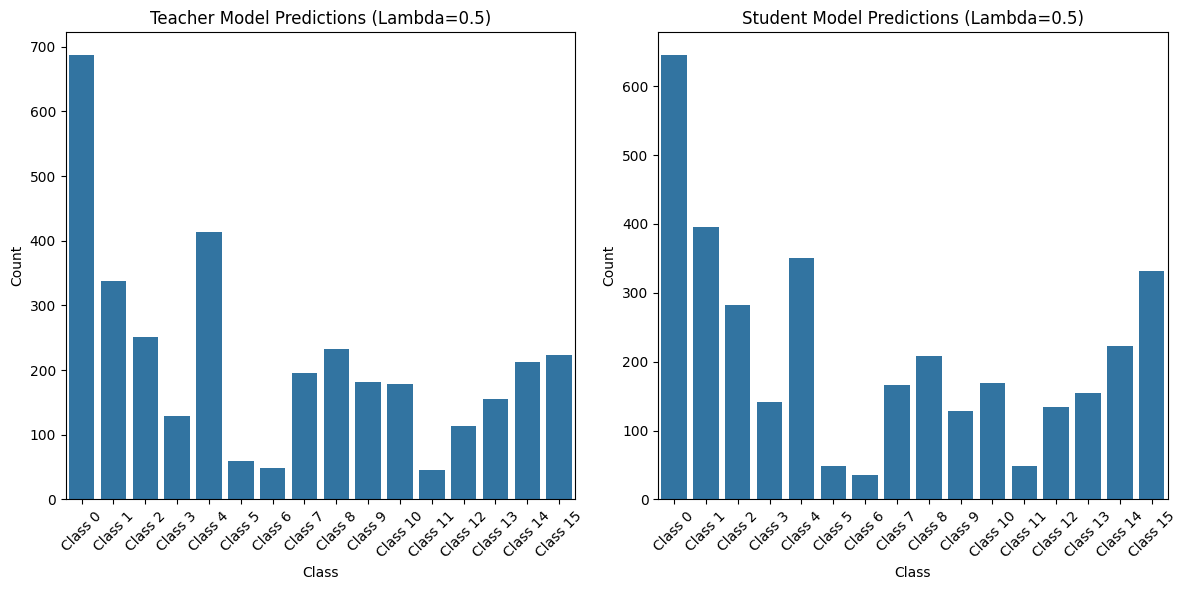

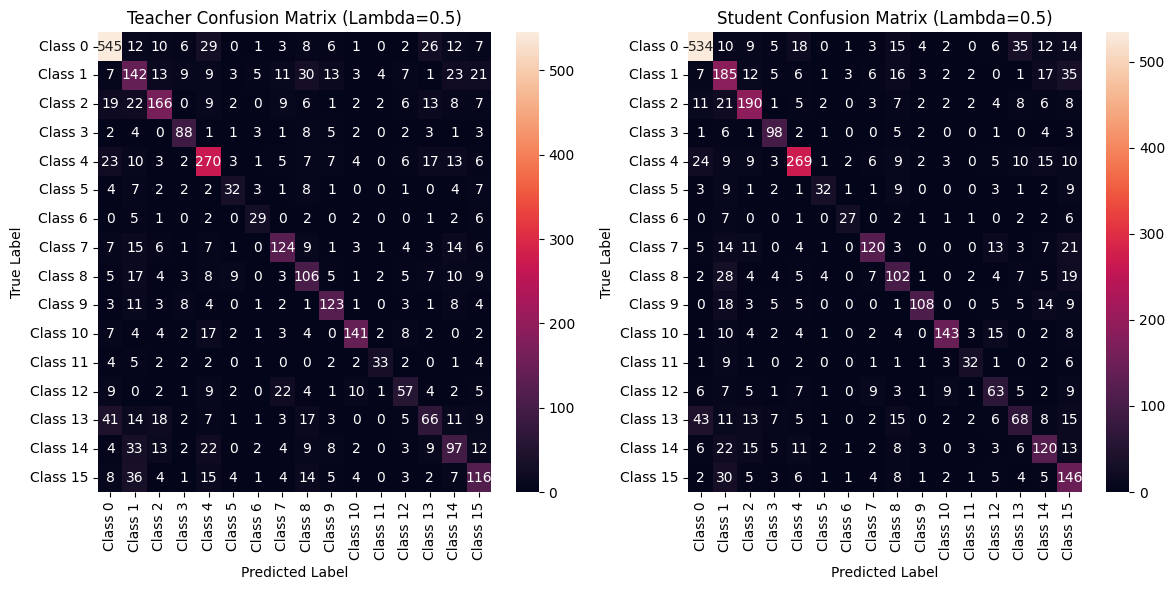

Classification Report - Teacher Model (Lambda=0.5)
              precision    recall  f1-score   support

     Class 0       0.79      0.82      0.80       668
     Class 1       0.42      0.47      0.45       301
     Class 2       0.66      0.61      0.63       272
     Class 3       0.68      0.71      0.70       124
     Class 4       0.65      0.72      0.68       377
     Class 5       0.53      0.43      0.48        74
     Class 6       0.59      0.58      0.59        50
     Class 7       0.64      0.61      0.62       202
     Class 8       0.45      0.55      0.50       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.71      0.75       199
    Class 11       0.73      0.55      0.63        60
    Class 12       0.50      0.44      0.47       129
    Class 13       0.43      0.33      0.37       198
    Class 14       0.46      0.44      0.45       220
    Class 15       0.52      0.52      0.52       224

    accuracy                 

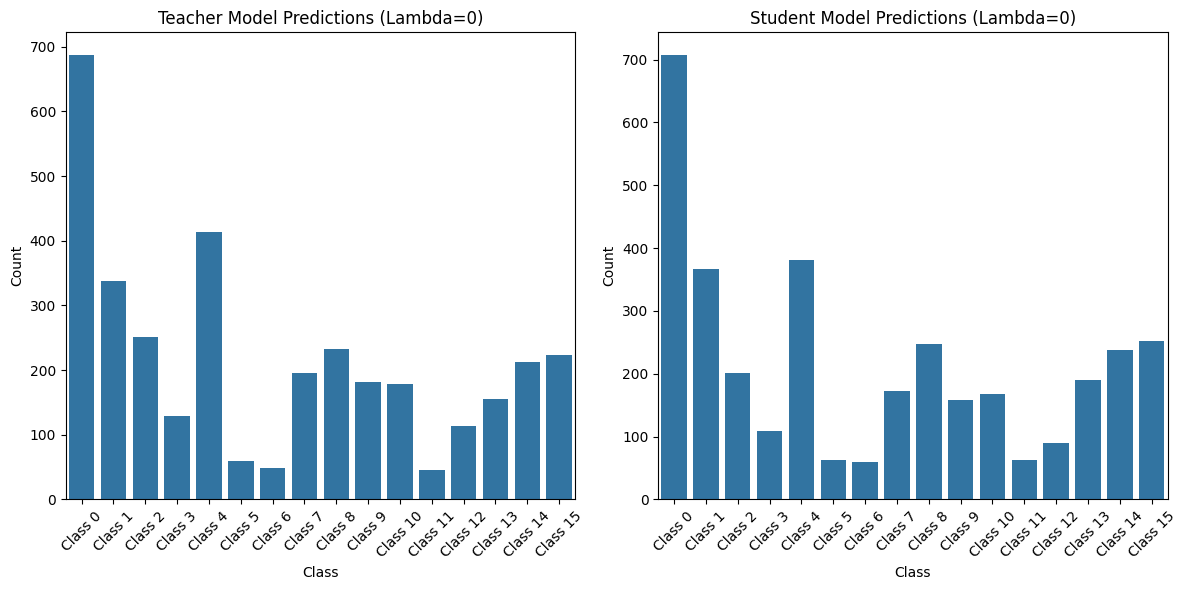

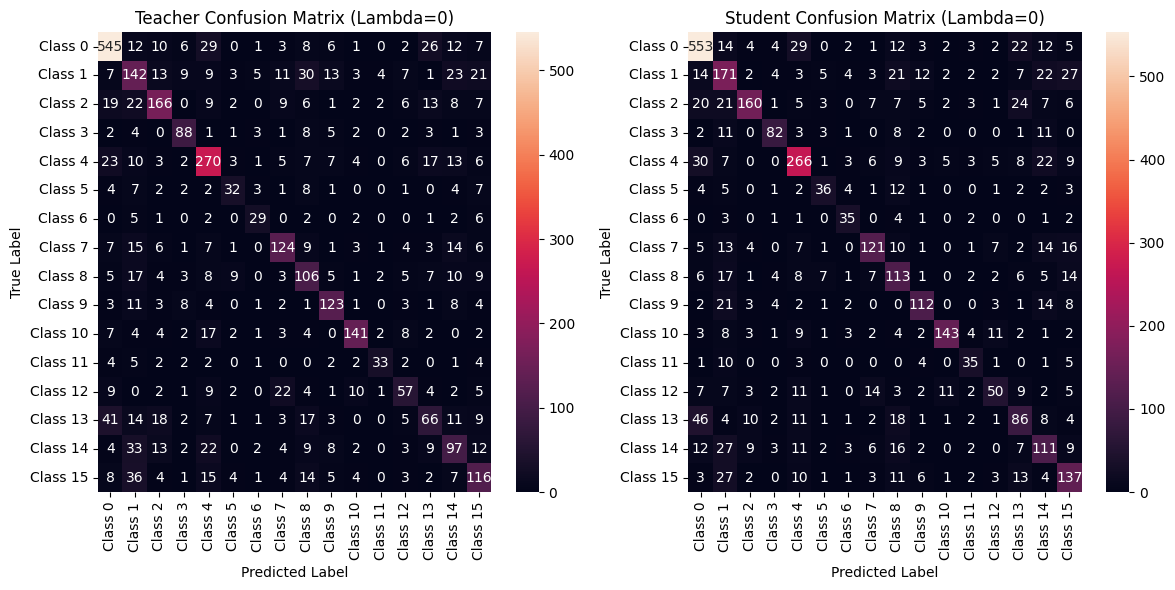

Classification Report - Teacher Model (Lambda=0)
              precision    recall  f1-score   support

     Class 0       0.79      0.82      0.80       668
     Class 1       0.42      0.47      0.45       301
     Class 2       0.66      0.61      0.63       272
     Class 3       0.68      0.71      0.70       124
     Class 4       0.65      0.72      0.68       377
     Class 5       0.53      0.43      0.48        74
     Class 6       0.59      0.58      0.59        50
     Class 7       0.64      0.61      0.62       202
     Class 8       0.45      0.55      0.50       194
     Class 9       0.68      0.71      0.69       173
    Class 10       0.79      0.71      0.75       199
    Class 11       0.73      0.55      0.63        60
    Class 12       0.50      0.44      0.47       129
    Class 13       0.43      0.33      0.37       198
    Class 14       0.46      0.44      0.45       220
    Class 15       0.52      0.52      0.52       224

    accuracy                   

In [34]:
def plot_combined_distribution(teacher_preds, student_preds, class_names, lmda):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.countplot(x=teacher_preds)
    plt.title(f'Teacher Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)

    plt.subplot(1, 2, 2)
    sns.countplot(x=student_preds)
    plt.title(f'Student Model Predictions (Lambda={lmda})')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(range(len(class_names)), class_names, rotation=45)
    plt.tight_layout()
    plt.show()

def plot_combined_confusion_matrix(all_labels, teacher_preds, student_preds, class_names, lmda):
    cm_teacher = confusion_matrix(all_labels, teacher_preds)
    cm_student = confusion_matrix(all_labels, student_preds)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(pd.DataFrame(cm_teacher, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Teacher Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    plt.subplot(1, 2, 2)
    sns.heatmap(pd.DataFrame(cm_student, index=class_names, columns=class_names), annot=True, fmt='g')
    plt.title(f'Student Confusion Matrix (Lambda={lmda})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

# Loop over each lambda value
for lmda in lmda_list_student:
    # Load teacher and student models
    teacher_model = torch.load(f'teacher_model_ckd_wider_lambda02.pth')
    student_model = torch.load(f'student_model_ckd_wider_lambda{lmda}.pth')

    # Generate predictions and compute metrics
    performance_metrics = compare_performance_metrics(teacher_model, student_model, testloader)
    all_labels = performance_metrics['all_labels']
    all_teacher_preds = performance_metrics['all_teacher_preds']
    all_student_preds = performance_metrics['all_student_preds']

    # Plot distribution and confusion matrices
    plot_combined_distribution(all_teacher_preds, all_student_preds, class_names_new, lmda)
    plot_combined_confusion_matrix(all_labels, all_teacher_preds, all_student_preds, class_names_new, lmda)

    # Print classification reports
    teacher_report = classification_report(all_labels, all_teacher_preds, target_names=class_names_new, zero_division=0)
    student_report = classification_report(all_labels, all_student_preds, target_names=class_names_new, zero_division=0)
    print(f'Classification Report - Teacher Model (Lambda={lmda})')
    print(teacher_report)
    print(f'Classification Report - Student Model (Lambda={lmda})')
    print(student_report)


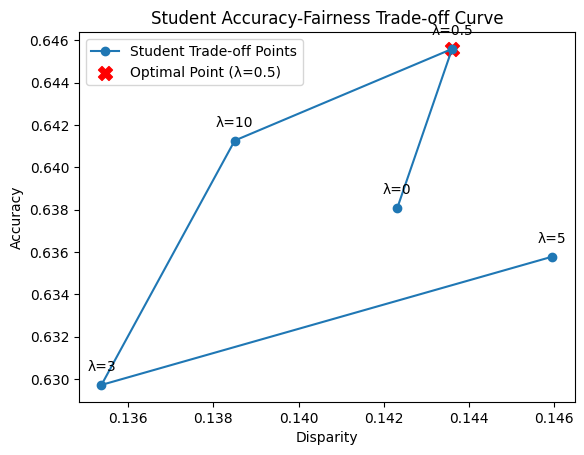

Optimal Lambda for Student: 0.5
Optimal Bias/Disparity for Student: 0.1436022922049628
Optimal Accuracy for Student: 0.6455988455988456
Optimal Weighted Ratio for Student: 0.56


In [35]:
def plot_bias_variance_tradeoff(model_results, model_type, lambdas):
    # Extract bias (disparity) and accuracy values
    if model_type == 'teacher':
        bias_values = [result['teacher_mean_abs_val_disparity'][0] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][0] for result in model_results.values()]
        model_name = "Teacher"
    elif model_type == 'student':
        bias_values = [result['student_mean_abs_val_disparity'] for result in model_results.values()]
        accuracy_values = [result['performance_metrics']['metrics']['accuracy'][1] for result in model_results.values()]
        model_name = "Student"
    else:
        raise ValueError("Invalid model type. Choose 'teacher' or 'student'.")

    # Weight for the trade-off (can be adjusted based on preference)
    bias_weight = 1

    # Calculate the weighted ratio
    weighted_ratios = np.array(accuracy_values) / (1 + bias_weight * np.array(bias_values))
    closest_to_one_index = np.argmin(np.abs(weighted_ratios - 1))
    optimal_bias = bias_values[closest_to_one_index]
    optimal_accuracy = accuracy_values[closest_to_one_index]
    optimal_ratio = weighted_ratios[closest_to_one_index]

    # Plotting the bias-variance trade-off curve
    plt.plot(bias_values, accuracy_values, marker='o', linestyle='-', label=f'{model_name} Trade-off Points')

    # Mark all points with their lambda values
    for i, (bias, acc, lmbda) in enumerate(zip(bias_values, accuracy_values, lambdas)):
        plt.annotate(f'λ={lmbda}', (bias, acc), textcoords="offset points", xytext=(0,10), ha='center')

    # Highlight the optimal point
    plt.scatter(optimal_bias, optimal_accuracy, color='r', s=100, marker='X', label=f'Optimal Point (λ={lambdas[closest_to_one_index]})')
    plt.xlabel('Disparity')
    plt.ylabel('Accuracy')
    plt.title(f'{model_name} Accuracy-Fairness Trade-off Curve')
    plt.legend()
    plt.show()

    # Print optimal values
    print(f"Optimal Lambda for {model_name}: {lambdas[closest_to_one_index]}")
    print(f"Optimal Bias/Disparity for {model_name}: {optimal_bias}")
    print(f"Optimal Accuracy for {model_name}: {optimal_accuracy}")
    print(f"Optimal Weighted Ratio for {model_name}: {optimal_ratio:.2f}")

# Plot for Teacher
# plot_bias_variance_tradeoff(lambda_results, 'teacher', lmda_list)

# Plot for Student
plot_bias_variance_tradeoff(lambda_results, 'student', lmda_list_student)
